
 ## DeePlexiCon
 ### Analyse and demultiplex Oxford Nanopore RNA barcoded with DNA Adaptors Directly from the Signal
 
 Supplement Jupyter Notebook for the paper "Barcoding and demultiplexing Oxford Nanopore direct RNA sequencing reads using deep learning"
 
Preparation:


In [1]:
# System support
from __future__ import print_function
import os
import platform
from copy import deepcopy
import re
import csv
import time
import configparser
# Math,Numpy and plot
import math
import numpy as np
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
#import PIL
#from PIL import Image
# Time series to 2D
import pyts
# Tensorflow - Keras
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
# Datasets, train test split
import pandas as pd
import sklearn
from sklearn import datasets, linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sn

Using TensorFlow backend.


In [2]:
def version_from_system(package):
    pkg_info=!pip show {package}
    return(pkg_info[1][9:])   

print("Python       version :",platform.python_version())
print("pip          version :",version_from_system('pip'))
print("Tensorflow   version :",tf.__version__)
print("Keras        version :",keras.__version__)
print("Numpy        version :",np.__version__)
print("Matplotlib   version :",matplotlib.__version__)
print("Pandas       version :",pd.__version__)
print("PyTs         version :",pyts.__version__)
print("Scikit-learn version :",sklearn.__version__)
#print("PIL          version :",PIL.__version__)
print("Seaborn      version :",sn.__version__)
print("PYCM         version :",version_from_system('pycm'))

Python       version : 3.7.3
pip          version : 19.1.1
Tensorflow   version : 1.13.1
Keras        version : 2.2.4
Numpy        version : 1.16.4
Matplotlib   version : 3.1.0
Pandas       version : 0.25.0
PyTs         version : 0.8.0
Scikit-learn version : 0.21.2
Seaborn      version : 0.9.0
PYCM         version : 2.4


In [3]:
# Parameters
run='rep5-on-rep2-4-test2'
gpus=1
epochs=40
input_cut=70000
input_data_paths=['/data/nanopore/James/Barcodes/rep5']
input_segment_paths=['/data/nanopore/James/Barcodes/rep5']#, '/data/nanopore/James/Barcodes/final-07-19/seg/rep2-split']
squiggle_max=199.0
squiggle_min=10
print_details_for=5
max_sample=70000
read_max=180000
smooth_by=1
num_classes=4
label_index=0
save_figures=True

In [4]:
!mkdir -p {run}

In [5]:
10# Python timeseries interface
from pyts.image import MarkovTransitionField, GramianAngularField, RecurrencePlot
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 6,
        }
# Python timeseries interface
def pyts_transform(name,transform,data,image_size,show=False,cmap='rainbow',img_index=0):
    try:
        X_transform = transform.fit_transform(data)
        if (show):
            tcn=transform.__class__.__name__
            if hasattr(transform, 'method'):
                tcn=tcn+'-'+transform.method
            plt.figure(figsize=(4, 4))
            plt.grid(b=None)
            plt.title(name,fontdict=font)
            plt.imshow(X_transform[0], cmap=cmap, origin='lower')
            if save_figures: plt.savefig(run+"/"+name+'-'+tcn+"_image_"+ str(img_index)+".svg", format="svg")
            plt.show()
        return(X_transform)
    except Exception as e:
        print('Error:', str(e))
        return([])
        
def mtf_transform(name,data,image_size = 500,show=False,img_index=0):
    transform = MarkovTransitionField(image_size)    
    return(name,pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))
    
def rp_transform(name,data,image_size = 500,show=False,img_index=0):
    # RP transformation
    transform = RecurrencePlot(dimension=1, 
                    threshold='percentage_points',
                    percentage=30)
    return(pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='binary',img_index=img_index))
    
def gasf_transform(name,data,image_size = 500,show=False,img_index=0):
    # GAF transformation
    transform = GramianAngularField(image_size, method='summation')
    return(pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))

def gadf_transform(name,data,image_size = 500,show=False,img_index=0):
    # GAF transformation
    transform = GramianAngularField(image_size, method='difference')
    return(name,pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))
     


In [6]:
def all_files_in_path(input_path,prefix, extension):
    return([f for f in os.listdir(input_path) if f.startswith(prefix) & f.endswith(extension)])

def full_paths_for_files_in_path(input_path,prefix, extension):
    return([input_path+'/'+f for f in os.listdir(input_path) if f.startswith(prefix) & f.endswith(extension)])

def labels_for(file_name):
    segments=re.split(r'[_\-\.]+', file_name)
    return(segments)

def label_for(file_name):
    return('BC'+labels_for(file_name)[label_index][-1])

def max_in_sequence(sequence):   
    return(max(np.amax([list(d.values()) for d in sequence]),0.01))

In [7]:
for file_name in all_files_in_path(input_segment_paths[0],'', 'dmux.tsv'):
    print(file_name,label_for(file_name))

BC2-rep5_cc6m_2459_T7_ecorv_cc2.txt_dmux.tsv BC2
BC3-rep5_cc6m_2595_T7_ecorv_cc3.txt_dmux.tsv BC3
BC1-rep5_R2_63_3.txt_dmux.tsv BC1
BC4-rep5_R2_117_1.txt_dmux.tsv BC4
BC3-rep5_R1_103_1.txt_dmux.tsv BC3
B4-rep5_cc6m_2709_T7_ecorv_cc4.txt_dmux.tsv BC4
BC1-rep5_cc6m_2244_T7_ecorv_cc1.txt_dmux.tsv BC1
BC2-rep5_R1_81_2.txt_dmux.tsv BC2


In [8]:
def read_segment_files(paths,postfix,usecols=[0,1,2, 8,9],index_column=1, names=['source','read_id','barcode', 'segment_start','segment_end']):
    all_segment_files=[]
    for path in paths:
        all_segment_files=all_segment_files+full_paths_for_files_in_path(path,'',postfix)
    print("Reading segment files:", all_segment_files)
    segments=[]
    for f in all_segment_files:
        segment_label=label_for(os.path.basename(f)) # Assuming Linux, may fail with Windows
        segment=pd.read_table(f, usecols=usecols, names=names, index_col=index_column, header=None, sep="\t",skiprows=[0])
        segment['label']=segment_label
        segments.append(segment)
    segments=pd.concat(segments)
    print(len(segments))
    segments = segments[~segments.index.duplicated(keep='first')]
    print(len(segments))
    return(segments)

In [9]:
print(full_paths_for_files_in_path(input_segment_paths[0],'', '.tsv'))

['/data/nanopore/James/Barcodes/rep5/BC2-rep5_cc6m_2459_T7_ecorv_cc2.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/rep5_cc6m_2244_T7_ecorv_cc1.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep5/rep5_R2_63_3.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep5/rep5_cc6m_2459_T7_ecorv_cc2.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep5/BC3-rep5_cc6m_2595_T7_ecorv_cc3.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/rep5_R1_103_1.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep5/BC1-rep5_R2_63_3.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/rep5_R2_117_1.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep5/rep5_cc6m_2709_T7_ecorv_cc4.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep5/BC4-rep5_R2_117_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC3-rep5_R1_103_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/B4-rep5_cc6m_2709_T7_ecorv_cc4.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC1-rep5_cc6m_2244_T7_ecorv_cc1.txt_dmux.tsv', '/data/

In [10]:
segments=read_segment_files(input_segment_paths, 'dmux.tsv')
segments

Reading segment files: ['/data/nanopore/James/Barcodes/rep5/BC2-rep5_cc6m_2459_T7_ecorv_cc2.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC3-rep5_cc6m_2595_T7_ecorv_cc3.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC1-rep5_R2_63_3.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC4-rep5_R2_117_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC3-rep5_R1_103_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/B4-rep5_cc6m_2709_T7_ecorv_cc4.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC1-rep5_cc6m_2244_T7_ecorv_cc1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep5/BC2-rep5_R1_81_2.txt_dmux.tsv']
139289
139289


source  \
read_id                                                                                   
00bc9e20-a105-4938-b457-3cc1f4c2c541  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
04beb0c9-7d3c-48df-b6cb-97f928849d26  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
191a6214-3fcd-4a96-bbe5-29a336dcbd93  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
1bb7e10c-056f-49a1-a06f-8e6c4be7649b  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
31a4ea48-713f-40cf-98e9-58dcd00e9484  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
...                                                                                 ...   
9abe64c4-d9fd-49e8-8733-88aa2b5f1cf1  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
3e9d3c58-1d77-4fcf-9319-e2b3513b727b  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
775b586c-5c66-4969-ba79-c583c8e4093a  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
2d2e8a83-89ce-40f6-8fb4-b8a66c5b39d8  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
87b16ded-37e8-4eb3-9909-daa6c8ec8eff  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   

                                     barcode  segment_start  segment_end label  
read_id                                                                         
00bc9e20-a105-4938-b457-3cc1f4c2c541    bc_2           1681         8103   BC2  
04beb0c9-7d3c-48df-b6cb-97f928849d26    bc_2            999         5032   BC2  
191a6214-3fcd-4a96-bbe5-29a336dcbd93    bc_2           5399        29908   BC2  
1bb7e10c-056f-49a1-a06f-8e6c4be7649b    bc_2           5258         9126   BC2  
31a4ea48-713f-40cf-98e9-58dcd00e9484    bc_2           3313         9562   BC2  
...                                      ...            ...          ...   ...  
9abe64c4-d9fd-49e8-8733-88aa2b5f1cf1    bc_2           2174         9104   BC2  
3e9d3c58-1d77-4fcf-9319-e2b3513b727b    bc_4          11174        14598   BC2  
775b586c-5c66-4969-ba79-c583c8e4093a    bc_2           1656        12104   BC2  
2d2e8a83-89ce-40f6-8fb4-b8a66c5b39d8    bc_4           2930         9659   BC2  
87b16ded-37e8-4eb3-9909-daa6c8ec8eff    bc_4            999         3783   BC2  

[139289 rows x 5 columns]

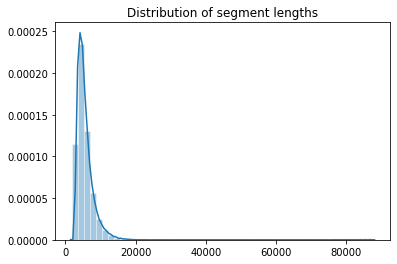

In [11]:
from matplotlib.ticker import FuncFormatter

seg_lengths=segments['segment_end']-segments['segment_start']+1
#seg_lengths=seg_lengths[seg_lengths<20000]
#print(seg_lengths[0:20])

plt.figure("Distribution of segment lengths")
plt.title("Distribution of segment lengths")
sn.set(rc={'figure.figsize':(18.7,10.27)})
sn.set_style("whitegrid")
sn.distplot(seg_lengths)#, bins=100, kde=False, color="blue", label="S1")
#plt.legend()
if save_figures: plt.savefig(run+"/seglengthdist1.svg", format="svg")
plt.show()
seg_lengths=None


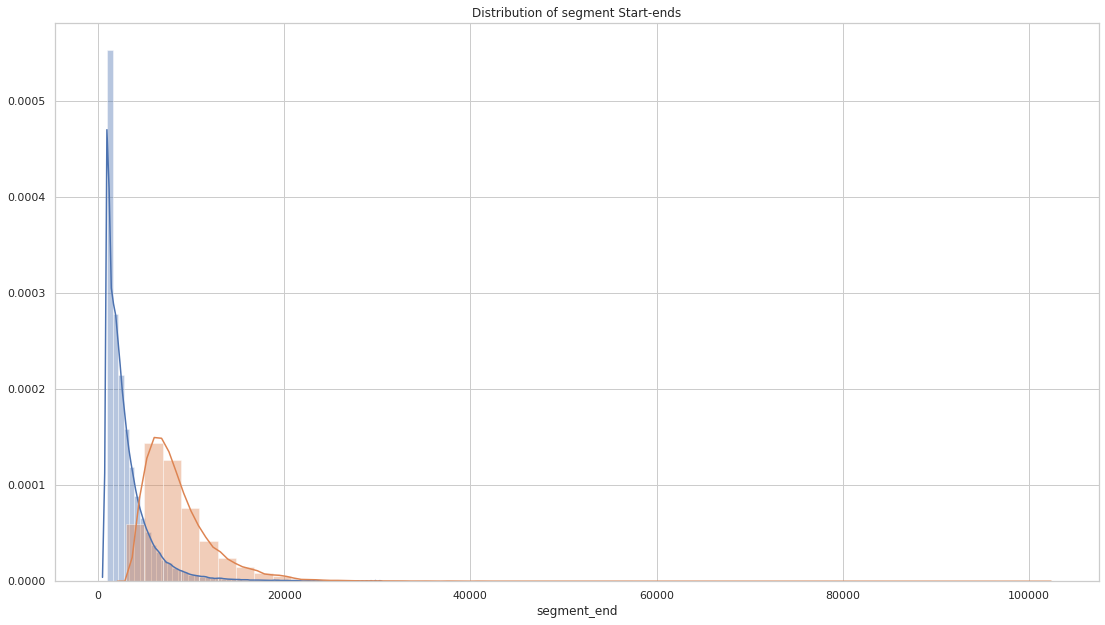

In [12]:

plt.figure("Distribution of segment Start-ends")
plt.title("Distribution of segment Start-ends")
sn.set(rc={'figure.figsize':(18.7,10.27)})
sn.set_style("whitegrid")
sn.distplot(segments['segment_start'][segments['segment_start']<30000])#, bins=100, kde=False, color="blue", label="S1")
sn.distplot(segments['segment_end'])#, bins=100, kde=False, color="blue", label="S1")
#plt.legend()
if save_figures: plt.savefig(run+"/segst-end-dist1.svg", format="svg")
plt.show()



In [13]:
segments.loc['03f3bb7f-7d34-4b17-b045-cdac3aab6a81']

KeyError: '03f3bb7f-7d34-4b17-b045-cdac3aab6a81'

In [14]:
segments.describe()

segment_start    segment_end
count  139289.000000  139289.000000
mean     3154.274652    8632.293814
std      3264.069559    4219.670007
min       999.000000    2999.000000
25%      1337.000000    5945.000000
50%      2240.000000    7641.000000
75%      3754.000000   10128.000000
max     84446.000000  101467.000000

In [15]:
far_ends= segments[segments['segment_end']>30000]

In [16]:
long_segments= segments[(segments['segment_end']-segments['segment_start'])>30000]

In [17]:
far_ends

source  \
read_id                                                                                   
ae118532-7bc2-41f4-88ac-c63a2e0e7dcb  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
99fd2dbb-bf50-41c4-99a4-98939285de1a  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
2bc3a467-3d4c-4f33-bcb1-9193992a213d  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
4ec40424-4765-4b0e-8021-b4bbdf246493  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
6c72ece7-6203-46f9-ba5b-eef073377a91  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
...                                                                                 ...   
d97d6a7f-a3b4-4582-844b-2d73cf6c39fd  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
449551f1-436f-4881-95aa-df996439811c  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
7732932a-2a00-4cf2-a916-957401d7b237  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
d8d963c5-9734-41a4-ab38-a3116d1016f2  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
7480b7ff-be8c-4425-a0c0-cba21dfeb945  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   

                                     barcode  segment_start  segment_end label  
read_id                                                                         
ae118532-7bc2-41f4-88ac-c63a2e0e7dcb    bc_3          28230        32975   BC2  
99fd2dbb-bf50-41c4-99a4-98939285de1a    bc_3          39896        48156   BC2  
2bc3a467-3d4c-4f33-bcb1-9193992a213d    bc_3          63319        67044   BC2  
4ec40424-4765-4b0e-8021-b4bbdf246493    bc_4          28609        31249   BC2  
6c72ece7-6203-46f9-ba5b-eef073377a91    bc_3          30352        38455   BC2  
...                                      ...            ...          ...   ...  
d97d6a7f-a3b4-4582-844b-2d73cf6c39fd    bc_2          26734        30381   BC1  
449551f1-436f-4881-95aa-df996439811c    bc_3          52748        54827   BC1  
7732932a-2a00-4cf2-a916-957401d7b237    bc_4          22170        30912   BC1  
d8d963c5-9734-41a4-ab38-a3116d1016f2    bc_2          46867        49258   BC1  
7480b7ff-be8c-4425-a0c0-cba21dfeb945    bc_2          40738        44387   BC2  

[544 rows x 5 columns]

In [18]:
long_segments

source  \
read_id                                                                                   
de6f0645-9cd1-4ff6-8478-9f61582a5b8b  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
c0132196-d644-472b-9f23-87f9ddabbbde  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
67922ebf-51a1-4811-8be7-f4b8885b130c  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
caa779f3-5f25-449c-8ce5-d338a579e126  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
63689b28-7d63-49ae-aec9-fb004a33832a  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
67b756f8-a56c-4495-86bb-99269bbc2d0f  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
c02d274e-2606-4409-a4d3-0779dc61f8cb  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
4aadc35e-c048-406f-aeaf-121a58f43a93  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
57eeb899-e5f7-4e18-bd02-e7618849e05b  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   
8550a861-dc2e-40f8-8994-c24782b4d43a  FAL15860_0fb89214060941a70ac9d88c39786885b7867...   

                                     barcode  segment_start  segment_end label  
read_id                                                                         
de6f0645-9cd1-4ff6-8478-9f61582a5b8b    bc_3            999        37872   BC3  
c0132196-d644-472b-9f23-87f9ddabbbde    bc_2            999        38930   BC1  
67922ebf-51a1-4811-8be7-f4b8885b130c    bc_1          40360       101467   BC1  
caa779f3-5f25-449c-8ce5-d338a579e126    bc_2            999        88610   BC1  
63689b28-7d63-49ae-aec9-fb004a33832a    bc_4           4804        86842   BC1  
67b756f8-a56c-4495-86bb-99269bbc2d0f    bc_2           1947        58450   BC1  
c02d274e-2606-4409-a4d3-0779dc61f8cb    bc_2           3018        60497   BC1  
4aadc35e-c048-406f-aeaf-121a58f43a93    bc_3            999        62616   BC1  
57eeb899-e5f7-4e18-bd02-e7618849e05b    bc_2           1705        33363   BC1  
8550a861-dc2e-40f8-8994-c24782b4d43a    bc_3            999        52288   BC1

In [19]:
fe_csv = far_ends.to_csv (run+'/far_ends.csv',  header=True)
ls_csv = long_segments.to_csv (run+'/long_segments.csv',  header=True)

In [20]:
offset=0
buffer=0
def segment_by_read_name(read_name):
    try:
        seg=segments.loc[read_name]
        return(seg['segment_start']+offset-buffer,seg['segment_end']+buffer,seg['label'])
    except:
        return(None,None, None)

In [21]:
segment_by_read_name('57eeb899-e5f7-4e18-bd02-e7618849e05b')

(1705, 33363, 'BC1')

In [22]:
files_to_process=[]
for path in input_data_paths:
    files_to_process=files_to_process+all_files_in_path(path,'','squiggle.tsv')

print (len(files_to_process))
for f in files_to_process:
    print(labels_for(f))

8
['rep5', 'cc6m', '2244', 'T7', 'ecorv', 'cc1', 'txt', 'squiggle', 'tsv']
['rep5', 'R2', '63', '3', 'txt', 'squiggle', 'tsv']
['rep5', 'cc6m', '2459', 'T7', 'ecorv', 'cc2', 'txt', 'squiggle', 'tsv']
['rep5', 'R1', '103', '1', 'txt', 'squiggle', 'tsv']
['rep5', 'R2', '117', '1', 'txt', 'squiggle', 'tsv']
['rep5', 'cc6m', '2709', 'T7', 'ecorv', 'cc4', 'txt', 'squiggle', 'tsv']
['rep5', 'R1', '81', '2', 'txt', 'squiggle', 'tsv']
['rep5', 'cc6m', '2595', 'T7', 'ecorv', 'cc3', 'txt', 'squiggle', 'tsv']


In [23]:
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
image_size=224
samples={'BC1':0,'BC2':0,'BC3':0,'BC4':0}
def compress_squiggle(squiggle,compress_factor):
    squiggle_len=len(squiggle)
    rem=squiggle_len%compress_factor
    if rem>0:
        return(np.mean(squiggle[0:squiggle_len-rem].reshape(-1,compress_factor), axis=1))
    return(squiggle)
    
def show_graph(squiggle_label,squiggle, trimmed_squiggle,segments=[], img_index=0):
    squiggle_for_plot=pd.DataFrame(np.trim_zeros(squiggle))
    plt.figure(figsize=(15,2))
    plt.grid(True)
    for seg in segments:
        plt.axvline(x=seg[0]/smooth_by, color=seg[2])
        plt.axvline(x=seg[1]/smooth_by, color=seg[2])
    plt.plot(squiggle_for_plot, linewidth=0.1, color='black')
    plt.title(squiggle_label)
    if save_figures: plt.savefig(run+"/"+squiggle_label+"-squiggle"+ str(img_index)+".svg", format="svg")
    plt.show()
    plt.figure(figsize=(15,2))
    plt.plot(trimmed_squiggle, linewidth=0.2, color='black')
    plt.title(squiggle_label)
    plt.grid(True)
    if save_figures: plt.savefig(run+"/"+squiggle_label+"-seg-squiggle-"+str(img_index)+".svg", format="svg")
    plt.show()
    
def process_file(data_path,file_to_process,  pos_from, pos_to):
    print('Processing file:', file_to_process)
    squiggles=[]
    squiggle_labels=[]
    start_from=2
    start=time.time()
    printed_details=0
    image_index=0
    labels=[]
    result=[]
    lines_read=0
    with open(data_path+'/'+file_to_process) as tsv:
        for line in csv.reader(tsv, dialect="excel-tab"):
#            try:
                squiggle_label=line[0]
                segment_start,segment_end, label=segment_by_read_name(squiggle_label)
                segments=[[segment_start, segment_end, 'r']]
                if segment_start is not None:
                    squiggle=np.array(line[start_from:], dtype=np.float32)
                    if len(squiggle)>=image_size:
                        lines_read=lines_read+1
                        #take average of every n points to compress by n
                        if (smooth_by > 1) and (len(squiggle)> smooth_by * image_size):
                            squiggle=compress_squiggle(squiggle,smooth_by) 
                            segment_start=int(segment_start/smooth_by)
                            segment_end=int(segment_end/smooth_by)
                        trimmed_squiggle=squiggle[segment_start:segment_end+1]
                        squiggle=squiggle[squiggle <= squiggle_max]
                        squiggle=squiggle[squiggle > squiggle_min]
                        trimmed_squiggle=trimmed_squiggle[trimmed_squiggle <= squiggle_max]
                        trimmed_squiggle=trimmed_squiggle[trimmed_squiggle > squiggle_min]
                        trimmed_squiggle=np.trim_zeros(trimmed_squiggle)
                        display_graph=printed_details<print_details_for
                        name=label+'-'+squiggle_label
                        if (display_graph):
                            print("Reading:", squiggle_label)
                            show_graph(name,squiggle,trimmed_squiggle,segments=segments,img_index=image_index)
                            image_index=image_index+1
                            printed_details=printed_details+1
#                        transformed_squiggle=mtf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
#                        transformed_squiggle=rp_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
#                        transformed_squiggle=gadf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
                        transformed_squiggle=gasf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
                        if (display_graph):
                            image_index=image_index+1
                        if len(transformed_squiggle)>0:
                            if samples[label]<max_sample:
                                transformed_squiggle=transformed_squiggle[None,...]
                                result.append([label,squiggle_label, transformed_squiggle])
                                samples[label]=samples[label]+1
                        else:
                            print("Transformation fails:", squiggle_label,len(transformed_squiggle))
                    else:
                        print("Short:", squiggle_label,len(squiggle))
                else:
                    print("No segment info for:", squiggle_label)
                if (lines_read>=read_max) or (min(samples.values())>=max_sample):
                    break
#            except Exception as e:
#               print('Error:', str(e),segment_start)
    print( "Number of Squiggles=", len(result))
    print(time.time()-start, ' seconds') 
    return(result)#[labels, squiggle_labels,squiggles])


/data/nanopore/James/Barcodes/rep5
File name= /data/nanopore/James/Barcodes/rep5/rep5_cc6m_2244_T7_ecorv_cc1.txt_squiggle.tsv
Processing file: rep5_cc6m_2244_T7_ecorv_cc1.txt_squiggle.tsv
Reading: 00121b8f-cde3-4417-87b2-ba370602a020


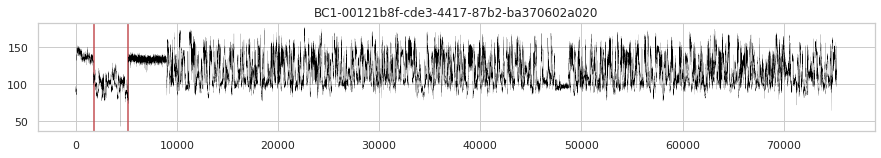

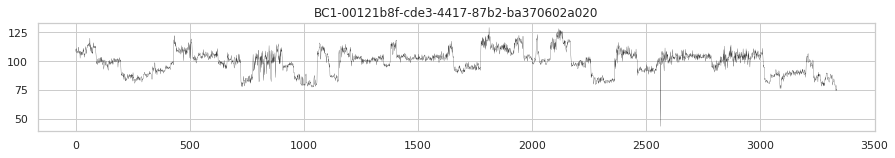

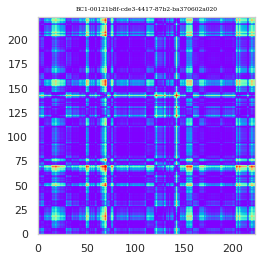

Reading: 034ccf55-7bd6-4da4-9397-1052bcf0cb26


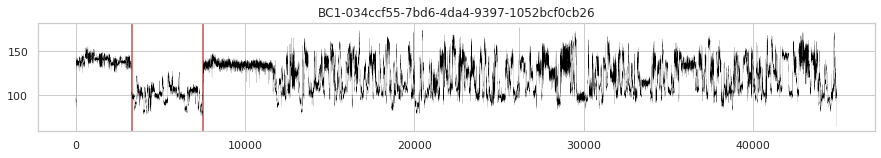

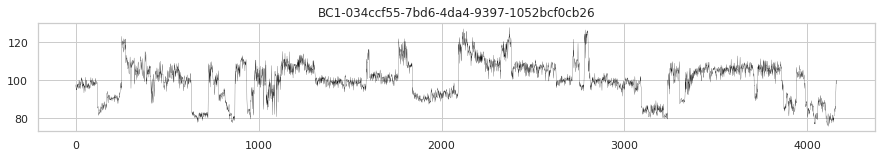

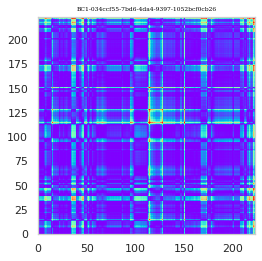

Reading: 048da718-3e17-47b3-b7cd-7f8d5782806e


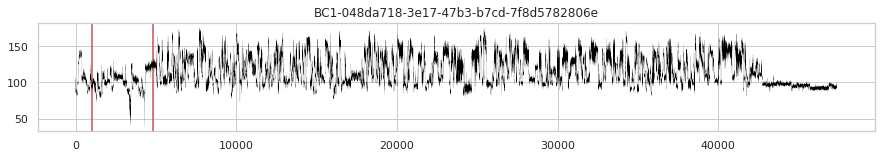

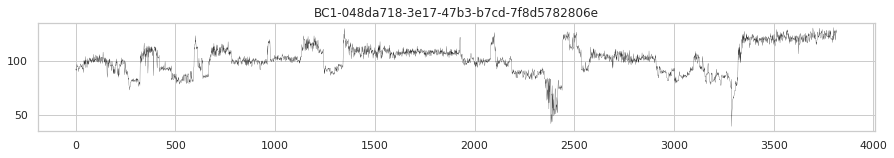

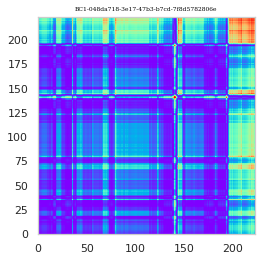

Reading: 04a3cb71-4117-420c-9861-520aed368e33


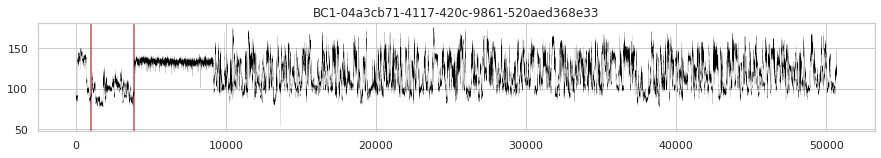

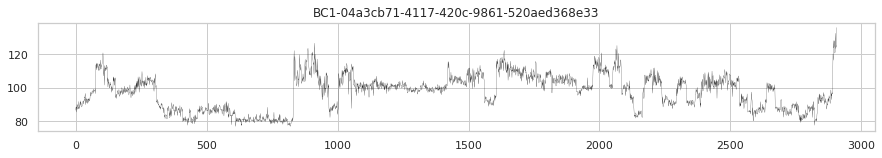

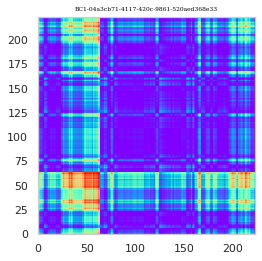

Reading: 0744a7ec-0a63-4ced-a0c6-8e371ffeb5f4


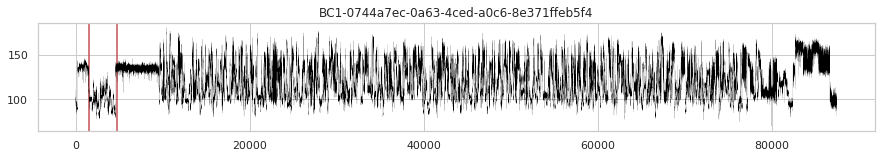

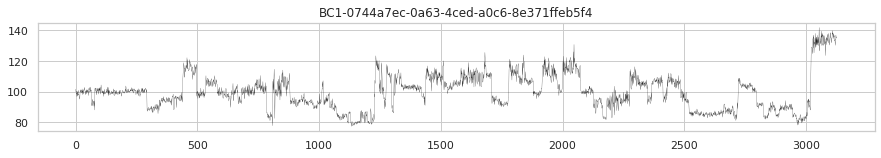

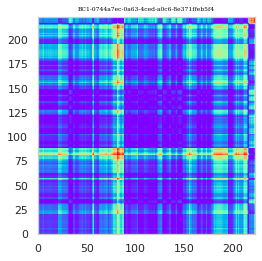

Number of Squiggles= 63724
1728.9319021701813  seconds
BC1 = 63724 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_R2_63_3.txt_squiggle.tsv
Processing file: rep5_R2_63_3.txt_squiggle.tsv
Reading: b2d902ea-b00e-48ed-9edb-5a5276a2d9f6


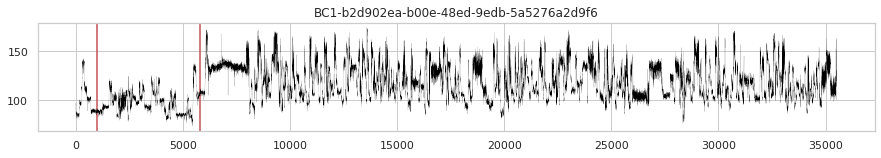

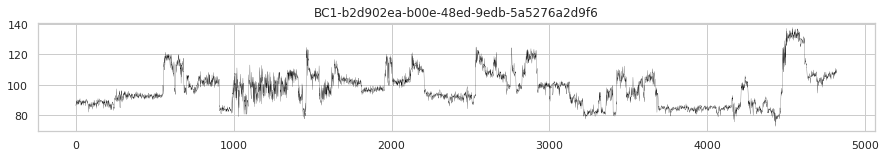

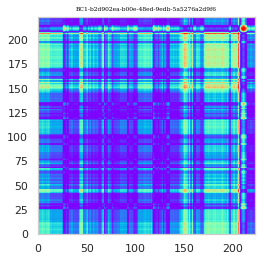

Reading: 0427ec53-3f96-47d2-8f0f-3d739c76afd6


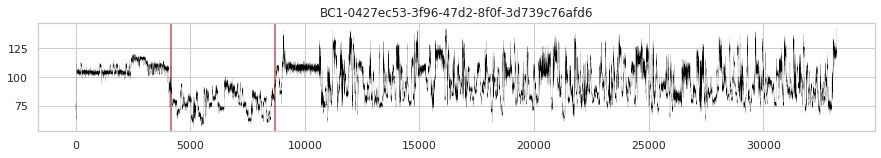

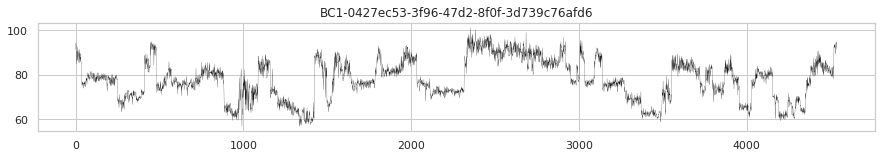

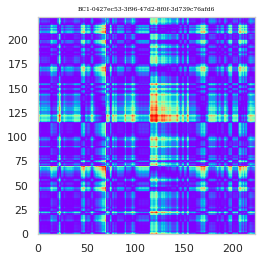

Reading: 0efd0abf-d4a8-401f-ba9a-ad4148854a92


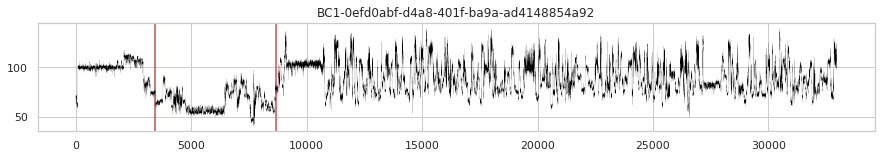

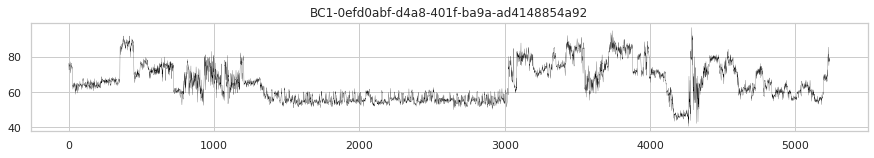

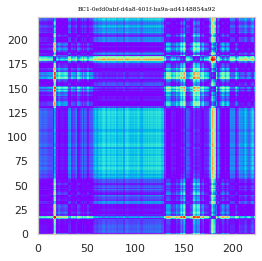

Reading: 16e33240-68e0-45a6-88b9-b7235b77f229


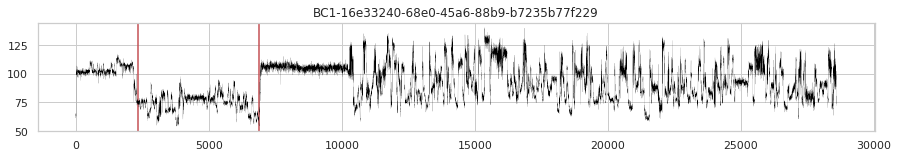

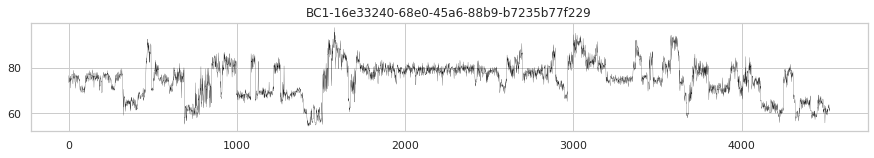

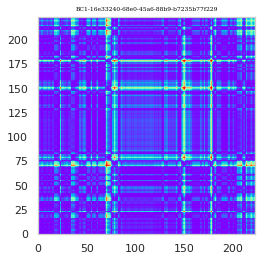

Reading: 1a779bfa-1942-4024-9769-ed61178b42ba


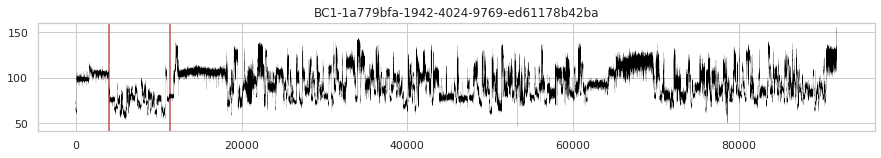

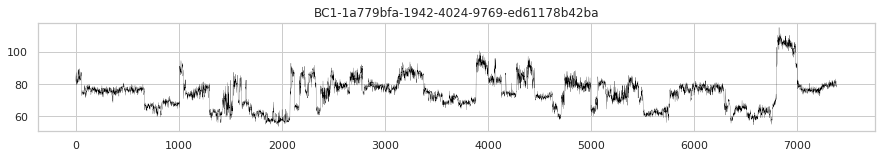

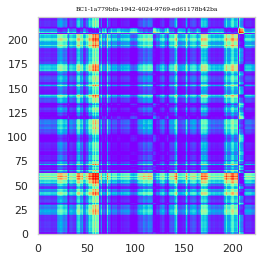

Number of Squiggles= 1561
29.829408168792725  seconds
BC1 = 65285 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_cc6m_2459_T7_ecorv_cc2.txt_squiggle.tsv
Processing file: rep5_cc6m_2459_T7_ecorv_cc2.txt_squiggle.tsv
Reading: 00bc9e20-a105-4938-b457-3cc1f4c2c541


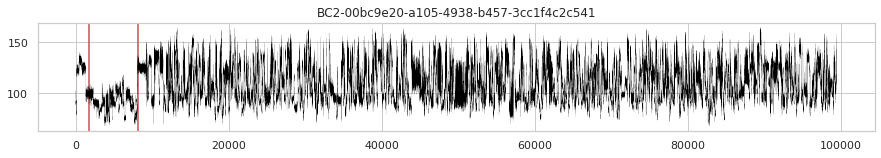

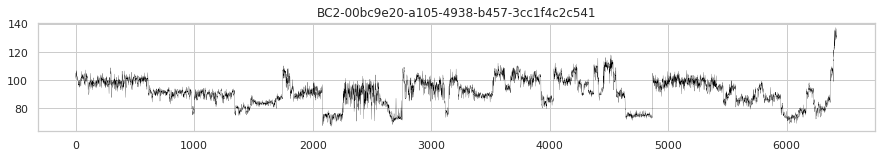

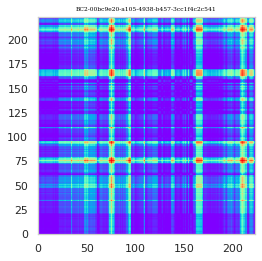

Reading: 04beb0c9-7d3c-48df-b6cb-97f928849d26


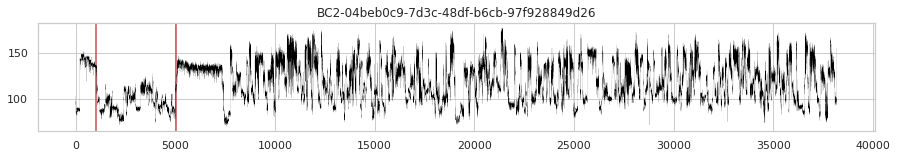

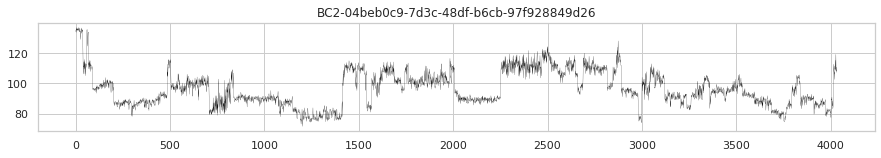

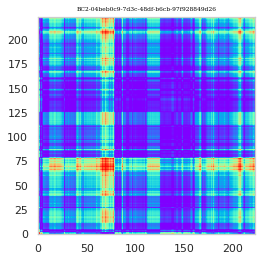

Reading: 191a6214-3fcd-4a96-bbe5-29a336dcbd93


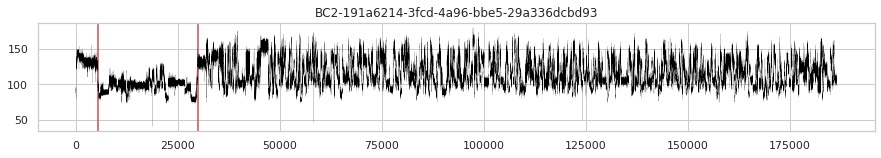

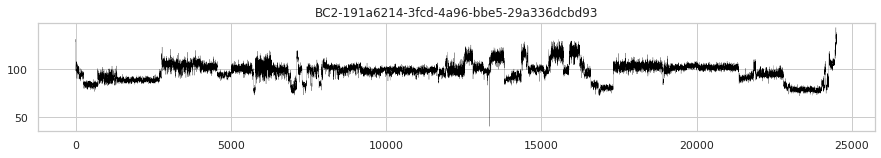

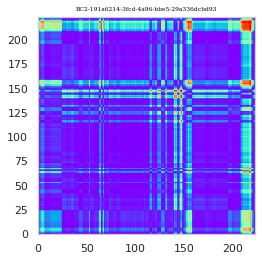

Reading: 1bb7e10c-056f-49a1-a06f-8e6c4be7649b


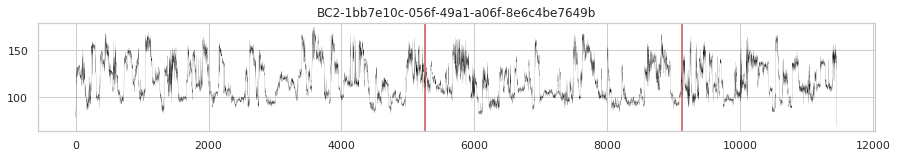

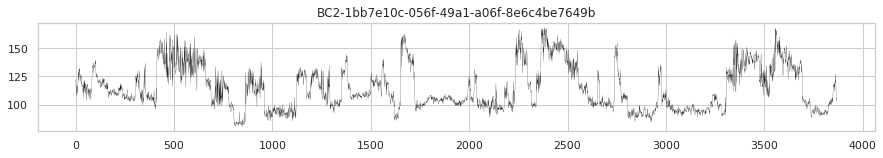

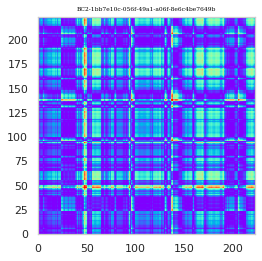

Reading: 31a4ea48-713f-40cf-98e9-58dcd00e9484


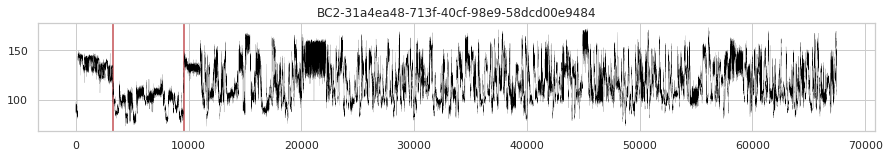

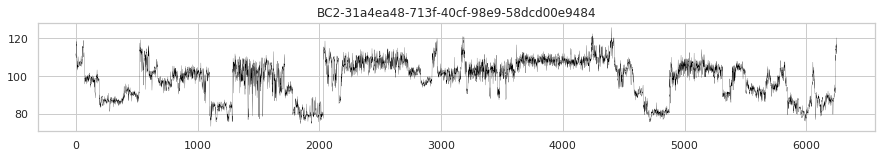

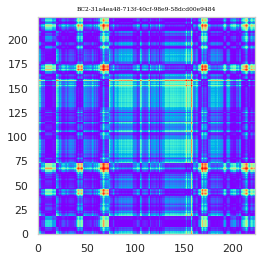

Number of Squiggles= 16455
566.0359792709351  seconds
BC1 = 65285 samples now
BC2 = 16455 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_R1_103_1.txt_squiggle.tsv
Processing file: rep5_R1_103_1.txt_squiggle.tsv
Reading: 04577fe9-f044-4e38-ab15-397166853164


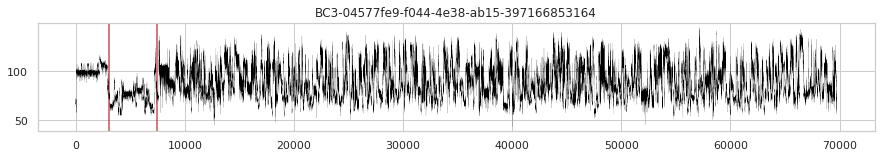

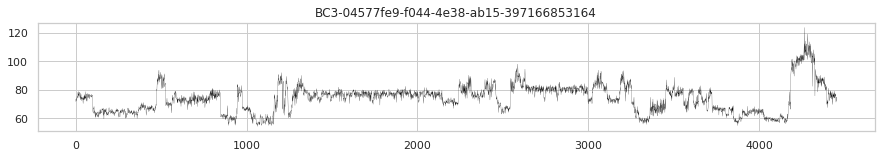

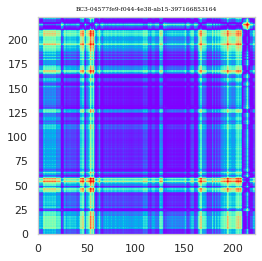

Reading: 09e6d492-f97d-465f-8832-6d55c54e3ce4


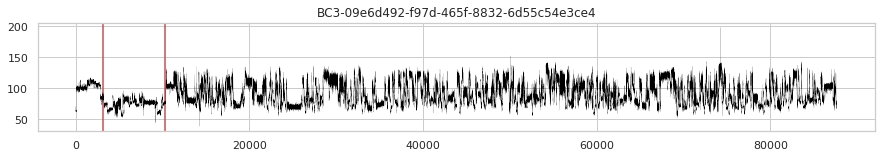

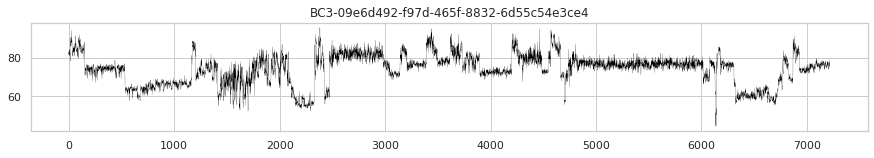

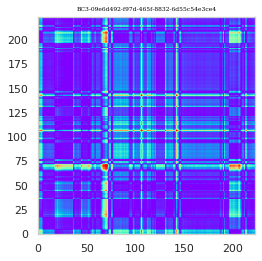

Reading: 35e26c72-1fd4-4172-9d41-c69e7880c50a


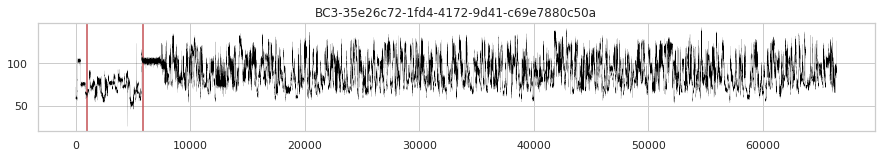

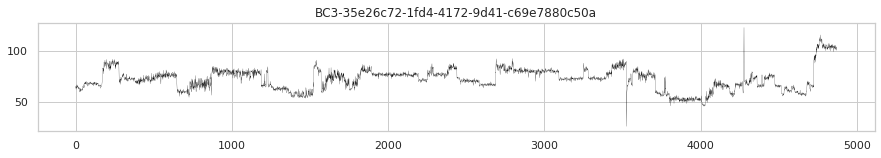

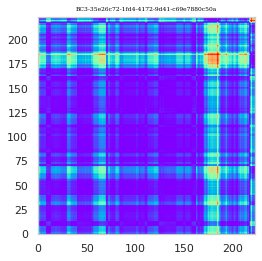

Reading: 75f29d63-3e6d-4eb2-80b5-2fce16dfee20


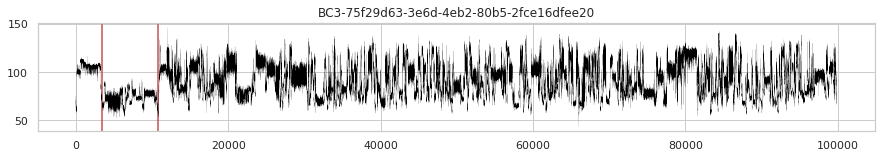

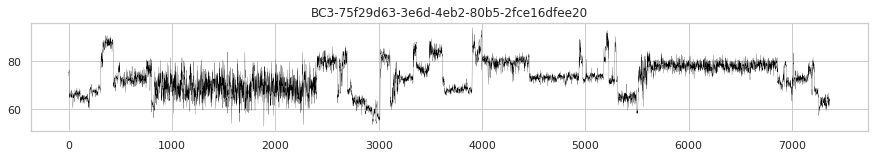

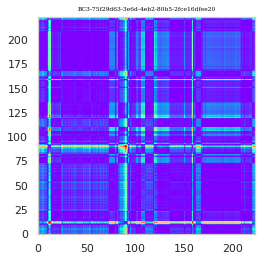

Reading: c63ae12d-587d-4230-b96f-eb629b3c6aea


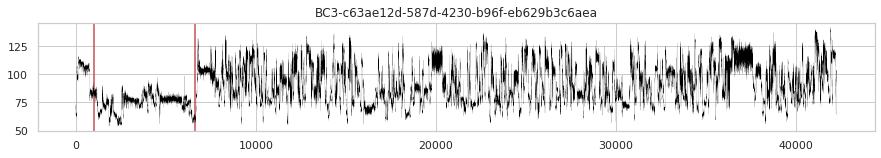

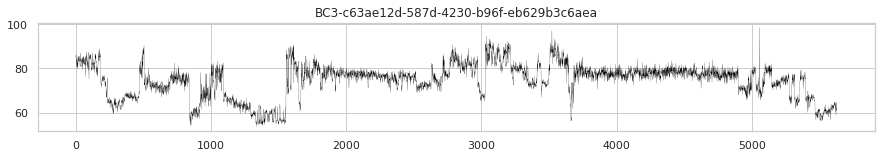

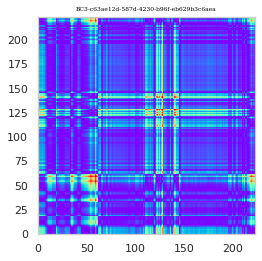

Number of Squiggles= 273
13.702959299087524  seconds
BC1 = 65285 samples now
BC2 = 16455 samples now
BC3 = 273 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_R2_117_1.txt_squiggle.tsv
Processing file: rep5_R2_117_1.txt_squiggle.tsv
Reading: 05c7c107-b114-41bb-9e68-4e276ccff651


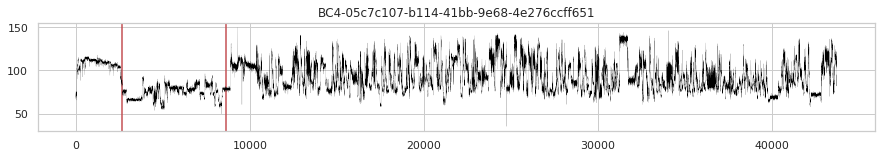

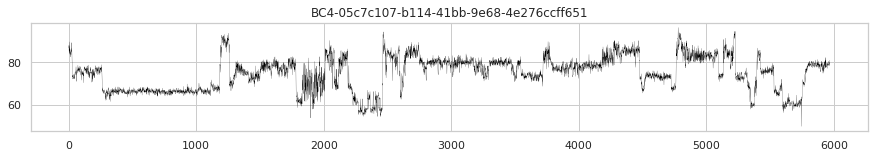

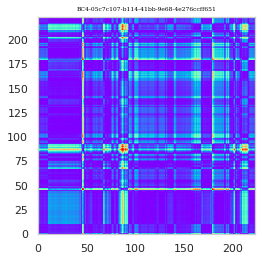

Reading: 090c67a9-a89f-481e-9494-d8e6471d705a


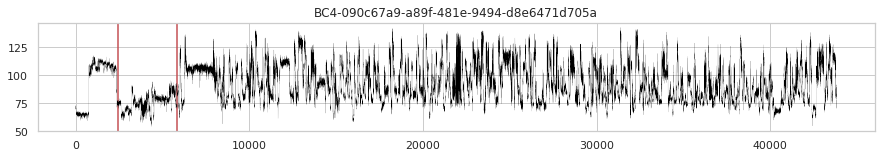

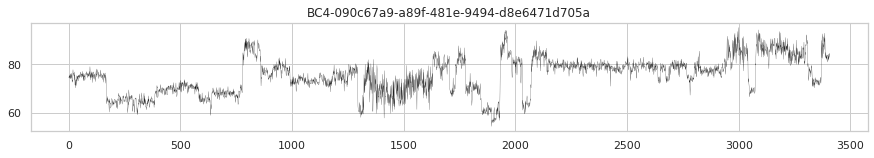

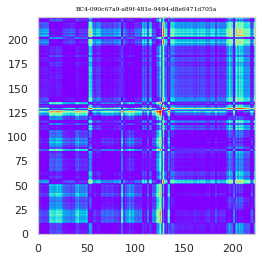

Reading: 1cef68bf-f830-43e4-9f54-62d72c8628e9


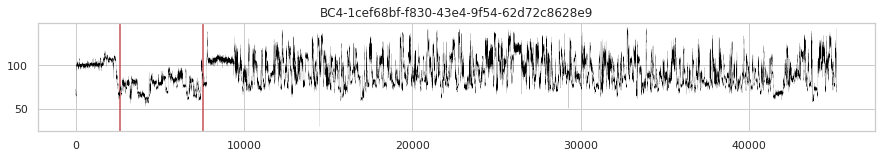

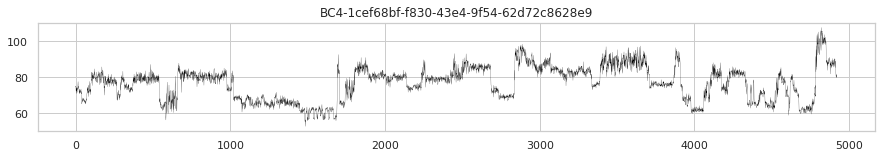

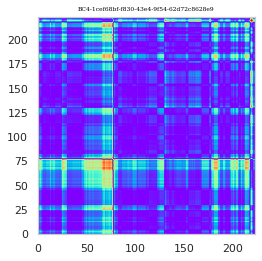

Reading: 22fe6c74-8e94-451d-b199-f6a284eb00d0


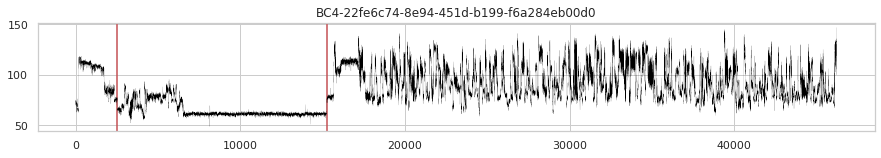

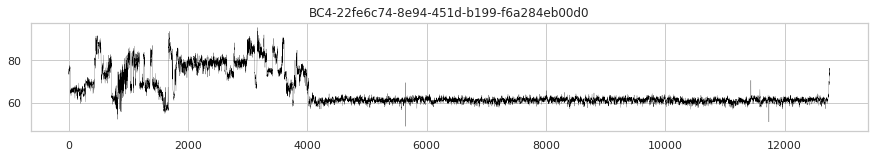

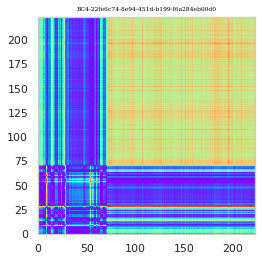

Reading: 2aa4b0e4-3214-489d-b474-6bbb185c05b8


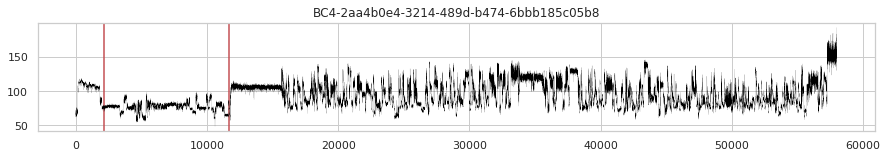

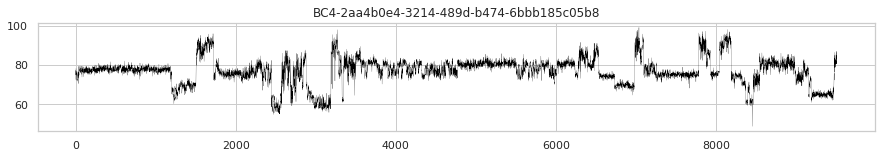

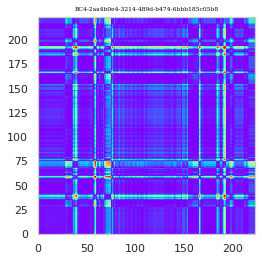

Number of Squiggles= 1670
40.58598852157593  seconds
BC1 = 65285 samples now
BC2 = 16455 samples now
BC3 = 273 samples now
BC4 = 1670 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_cc6m_2709_T7_ecorv_cc4.txt_squiggle.tsv
Processing file: rep5_cc6m_2709_T7_ecorv_cc4.txt_squiggle.tsv
Reading: 022a283d-e777-4149-a40a-f1eb65c0fea7


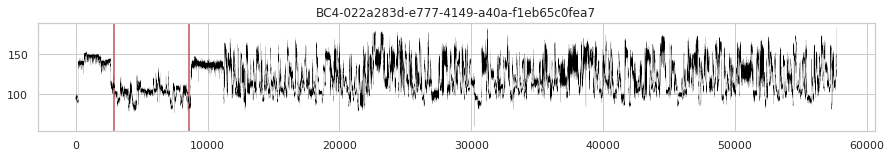

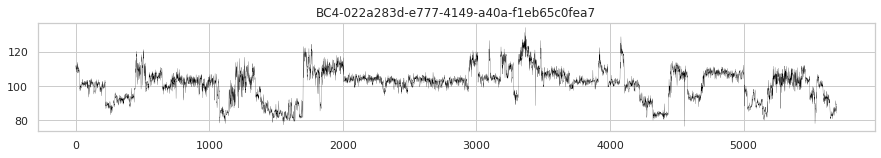

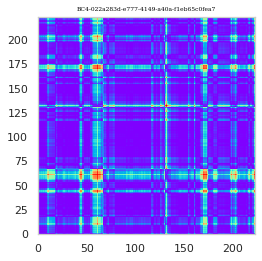

Reading: 0266ccf0-e09a-4b45-b537-ed979ed2096f


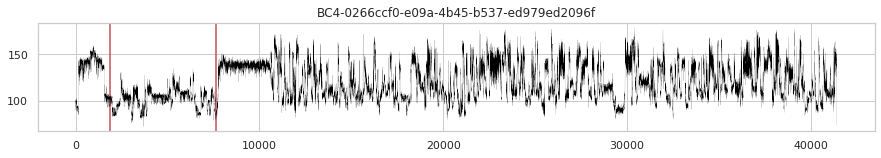

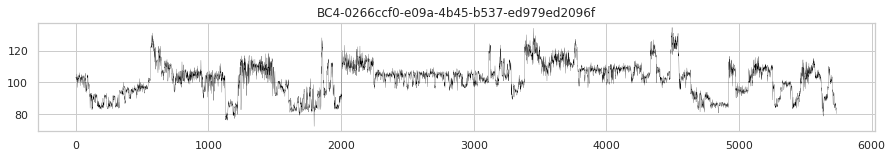

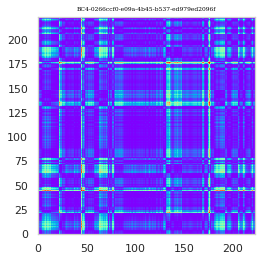

Reading: 0453ca02-2595-49ad-b734-3ee2efc70f82


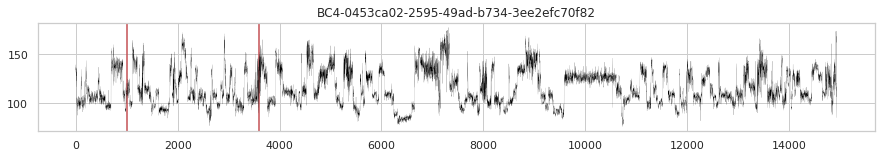

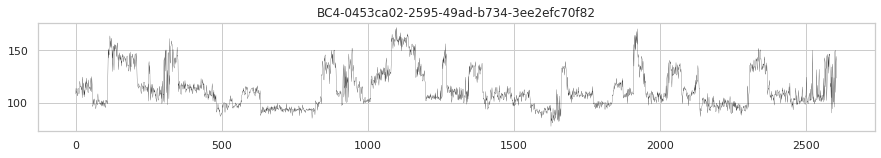

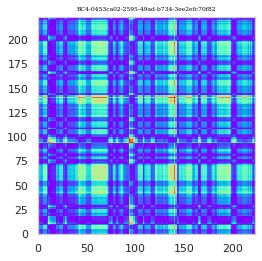

Reading: 05b1d0cd-8c72-4502-8986-6fe5d16ab791


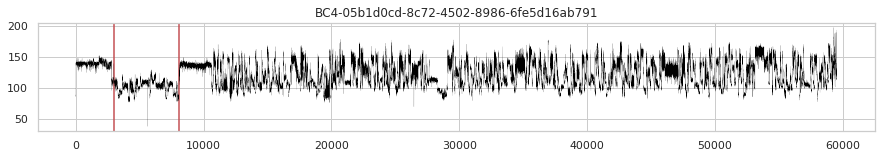

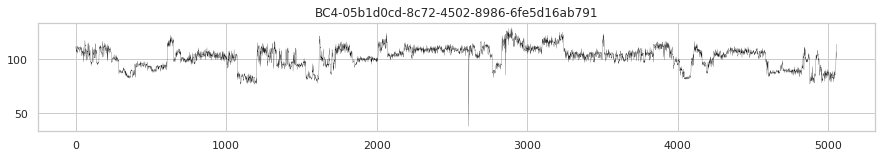

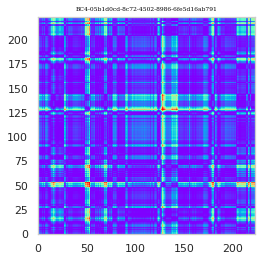

Reading: 10751d89-0a36-4d14-b382-ca90e0554fef


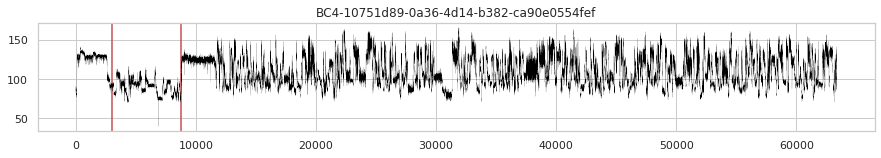

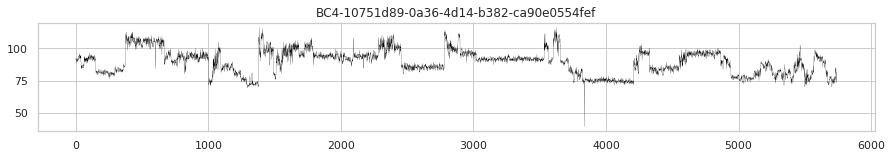

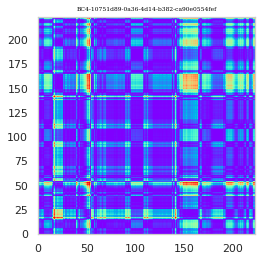

Number of Squiggles= 20643
794.9766430854797  seconds
BC1 = 65285 samples now
BC2 = 16455 samples now
BC3 = 273 samples now
BC4 = 22313 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_R1_81_2.txt_squiggle.tsv
Processing file: rep5_R1_81_2.txt_squiggle.tsv
Reading: 69b9e3d8-3a36-476b-8102-70a5b0033e18


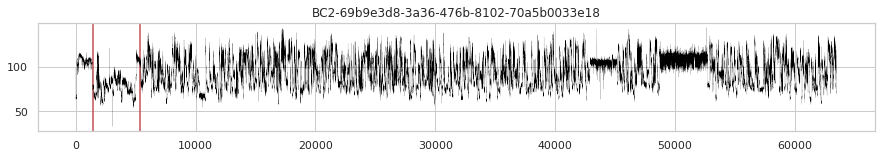

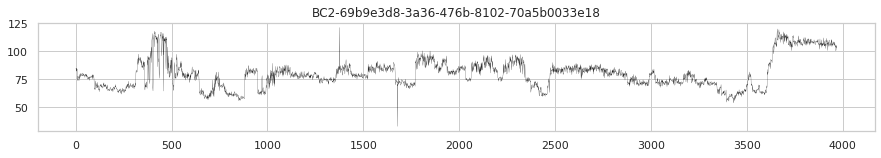

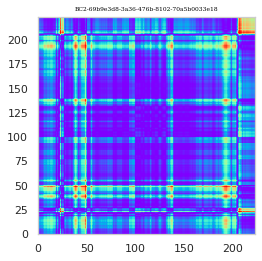

Reading: 17c54b2c-21fa-486c-a2be-bc568f635465


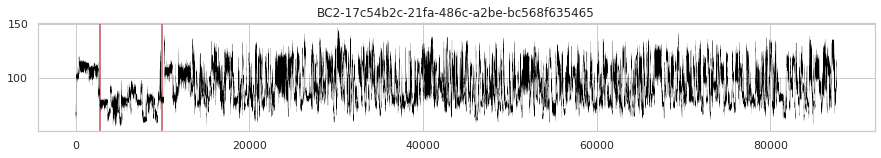

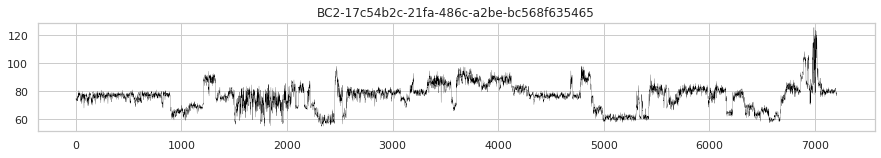

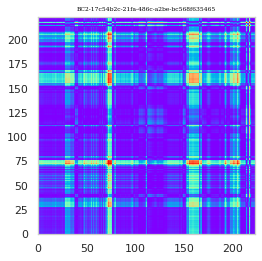

Reading: 92f80741-38cc-4fe4-b7b8-06dfc7d7094c


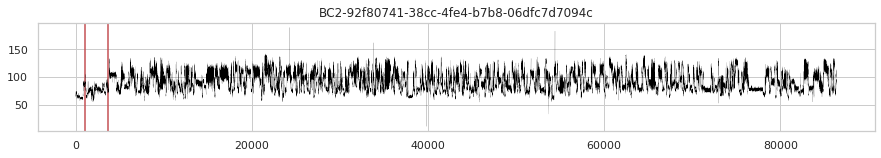

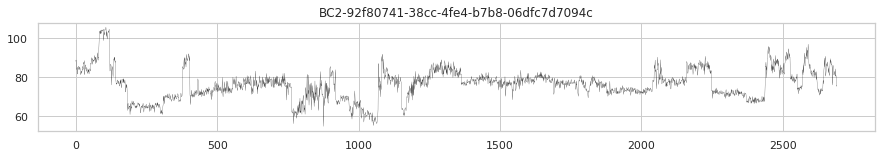

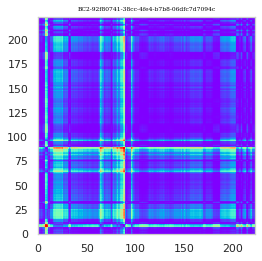

Reading: f9e33a41-4999-40c9-abc7-cf7c93f61be5


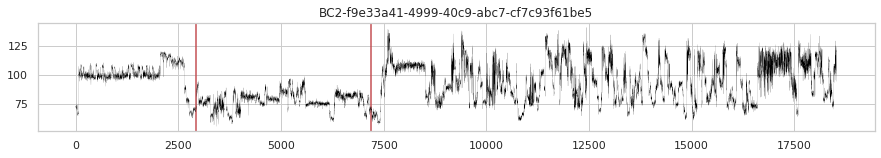

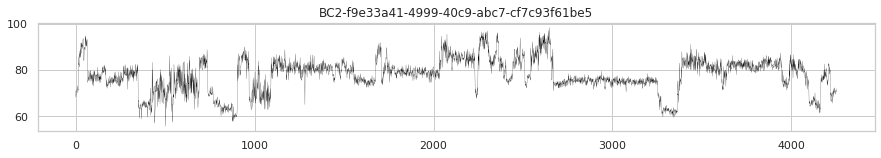

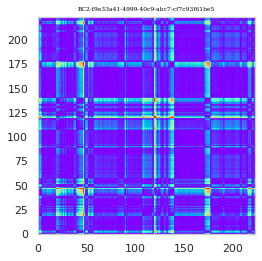

Reading: 15dadd46-b665-4aec-b246-14fd917dc894


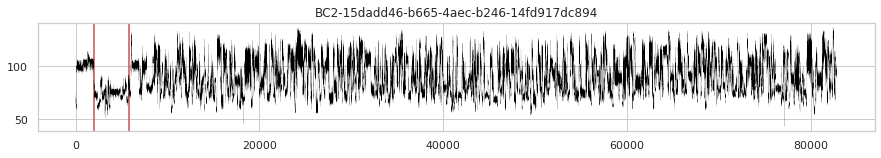

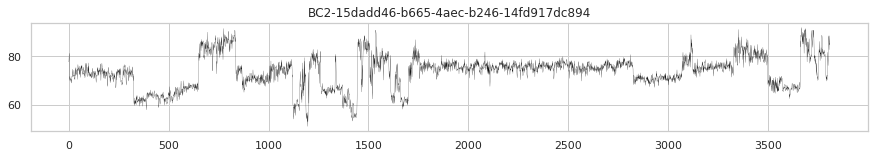

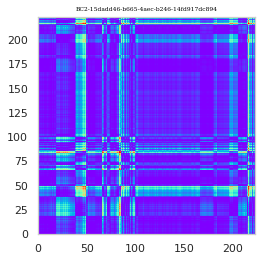

Number of Squiggles= 39
7.396522283554077  seconds
BC1 = 65285 samples now
BC2 = 16494 samples now
BC3 = 273 samples now
BC4 = 22313 samples now
File name= /data/nanopore/James/Barcodes/rep5/rep5_cc6m_2595_T7_ecorv_cc3.txt_squiggle.tsv
Processing file: rep5_cc6m_2595_T7_ecorv_cc3.txt_squiggle.tsv
Reading: 0a86bcad-490c-4722-8374-ba6bb44561fd


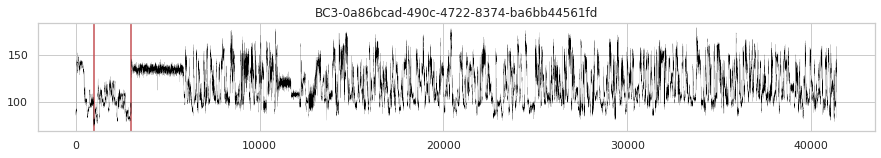

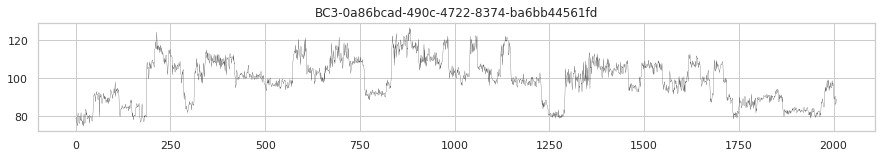

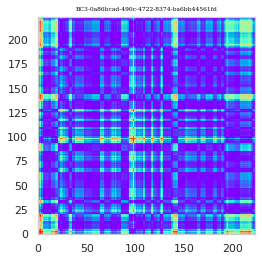

Reading: 0d6064f3-78dd-4f77-b73d-e0489bdd33a6


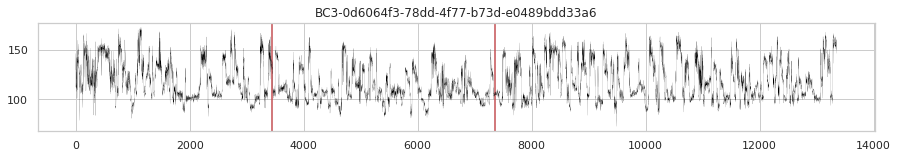

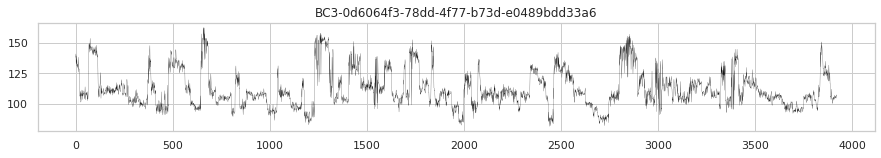

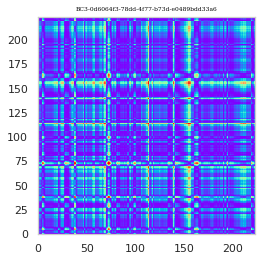

Reading: 2b30f3ed-2689-4424-b422-d4517d7a0769


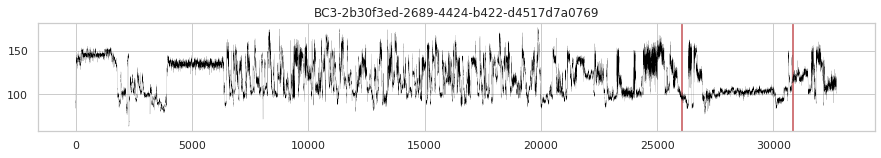

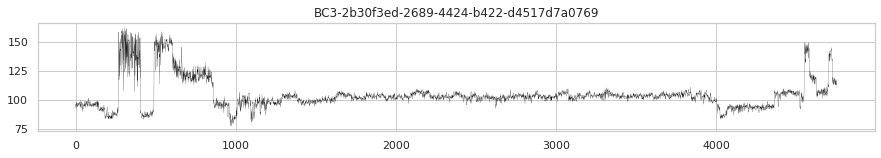

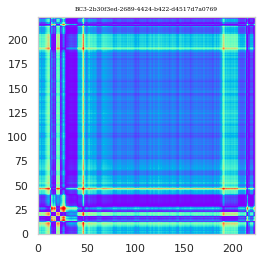

Reading: 319e7b9b-dfa2-4bd4-ba49-32b5a693e7bd


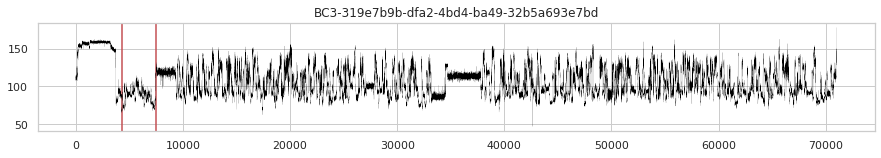

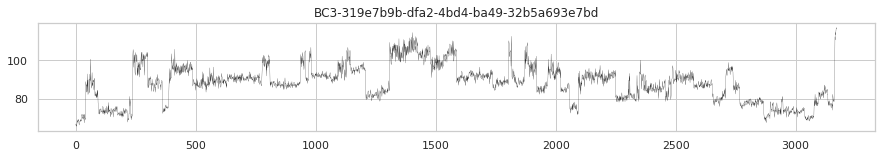

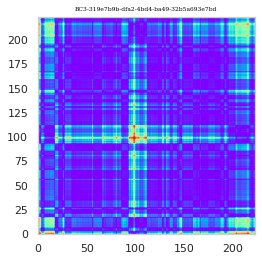

Reading: 395d220c-bf23-4614-8543-633863330c86


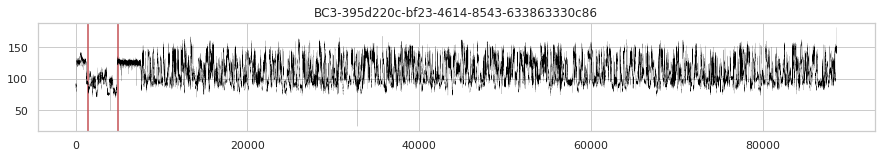

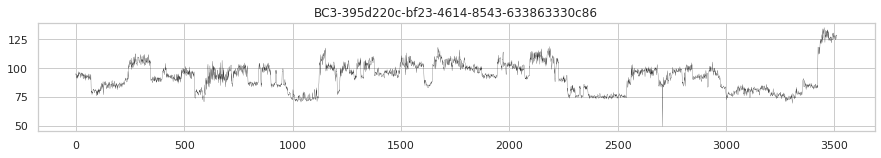

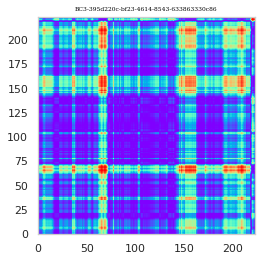

Number of Squiggles= 34924
1346.9670605659485  seconds
BC1 = 65285 samples now
BC2 = 16494 samples now
BC3 = 35197 samples now
BC4 = 22313 samples now
CPU times: user 1h 14min 44s, sys: 9min 43s, total: 1h 24min 27s
Wall time: 1h 15min 29s


In [24]:
%%time

result={}
for data_path in input_data_paths:
    print(data_path)
    for fn in all_files_in_path(data_path,'','squiggle.tsv'):
        file_name=data_path+'/'+fn
        print('File name=',file_name)
        summary=process_file(data_path,fn, 5, 10)
        for label, squiggle_label, img in summary:
            if label not in result:
                result[label]=[]
            result[label].append([squiggle_label,img])
        for key,value in result.items():
            print(key, '=',len(value), 'samples now')
#del segments #No need after conversion

In [26]:
print(samples)

{'BC1': 65285, 'BC2': 16494, 'BC3': 35197, 'BC4': 22313}


In [ ]:
for i,v in times.items():
    print(i, sum(v), len(v),sum(v)/len(v))

In [45]:
#%%time
#import pickle
#with open('images.px', 'wb') as fp:
#    pickle.dump(result, fp, protocol=4) 

4.248104572296143  seconds


In [48]:
#%%time
#with open ('images.px', 'rb') as fp:
#    result = pickle.load(fp, encoding="bytes") 

0.46711015701293945  seconds


In [27]:
print([len(val) for val in result.values()])

[65285, 16494, 35197, 22313]


In [26]:
for key,value in result.items():
    print(key,len(value))
    
#SH1= 75685  SH2= 82725  SH3= 60041  SH4= 80367 Previous runs
#BC1 45000 BC2 16494 BC3 35197 BC4 22313 Previous runs

In [28]:
np.mean([np.mean(elm[1]) for elm in result['BC4']])

-0.7071666480783511

In [29]:
64000+16494+35197+22313

138004

In [30]:
from sklearn.utils import shuffle

train_size=0
test_size=140000
test_val_split=0.99999
def prep_data(in_labels,raw_data,desired_size,y_value,shuffle_data=False,):
    data=deepcopy(raw_data)
    labels=deepcopy(in_labels)
    if shuffle_data:
        labels,data=shuffle(in_labels,data)
    data=data[0:desired_size]
    labels=labels[0:desired_size]
    results = np.empty((len(data),num_classes))
    results[0:len(data)]=y_value
    return(labels,data,results)
    
sh1=np.array(result['BC1'])
sh2=np.array(result['BC2'])
sh3=np.array(result['BC3'])
sh4=np.array(result['BC4'])
sh1d=np.vstack(sh1[:,1])
sh2d=np.vstack(sh2[:,1])
sh3d=np.vstack(sh3[:,1])
sh4d=np.vstack(sh4[:,1])
#result=None
labels,data,exp_values=prep_data(sh1[:,0],sh1d,train_size,[1,0,0,0],shuffle_data=True)
LX=labels
X=np.array(data)
y=exp_values
labels,data,exp_values=prep_data(sh1[:,0][train_size:],sh1d[train_size:],test_size,[1,0,0,0],shuffle_data=False)
LX_test=labels
X_test=np.array(data)
Y_test=exp_values
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', LX.shape, X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh2[:,0],sh2d,train_size,[0,1,0,0],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh2[:,0][train_size:],sh2d[train_size:],test_size,[0,1,0,0],shuffle_data=False)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test = np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh3[:,0],sh3d,train_size,[0,0,1,0],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh3[:,0][train_size:],sh3d[train_size:],test_size,[0,0,1,0],shuffle_data=False)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test =np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh4[:,0],sh4d,train_size,[0,0,0,1],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh4[:,0][train_size:],sh4d[train_size:],test_size,[0,0,0,1],shuffle_data=True)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test = np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

#del result,sh1,sh2,sh3,sh4,sh1d,sh2d,sh3d,sh4d
#X_test_labels, X_test, Y_test=
#X_validation_labels, X_validation, Y_validation =train_test_split(X_test, y_test, test_size=0.5, shuffle=True)
LX_test, X_test, Y_test=shuffle(LX_test, X_test, Y_test)
split_point=int(len(X_test)*test_val_split)
print("splitting at=",split_point)
LX_validation=LX_test[split_point:]
X_validation=X_test[split_point:]
Y_validation=Y_test[split_point:]
LX_test=LX_test[0:split_point]
X_test=X_test[0:split_point]
Y_test=Y_test[0:split_point]

print('Tst LX=', len(LX_test))
print('Tst X=', X_test.shape)
print('Tst y=',Y_test.shape)
print('Val LX=', len(LX_validation))
print('Val X=', X_validation.shape)
print('Val y=',Y_validation.shape)


lx,x,y,labels, lxt, x_test y_test shapes= (0,) (0, 1, 224, 224) (0, 4) 65285 65285 (65285, 1, 224, 224) (65285, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 16494 81779 (81779, 1, 224, 224) (81779, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 35197 116976 (116976, 1, 224, 224) (116976, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 22313 139289 (139289, 1, 224, 224) (139289, 4)
splitting at= 139287
Tst LX= 139287
Tst X= (139287, 1, 224, 224)
Tst y= (139287, 4)
Val LX= 2
Val X= (2, 1, 224, 224)
Val y= (2, 4)


In [31]:
X_test[0]

array([[[-0.87298458, -0.89183031, -0.87223378, ..., -0.89157465,
         -0.99458799,  0.25200736],
        [-0.89183031, -0.9092431 , -0.89113387, ..., -0.87270894,
         -0.98962515,  0.21302218],
        [-0.87223378, -0.89113387, -0.87148091, ..., -0.89226976,
         -0.99474653,  0.25349466],
        ...,
        [-0.89157465, -0.87270894, -0.89226976, ..., -0.12101905,
         -0.46816842, -0.66294078],
        [-0.99458799, -0.98962515, -0.99474653, ..., -0.46816842,
         -0.75333413, -0.35118789],
        [ 0.25200736,  0.21302218,  0.25349466, ..., -0.66294078,
         -0.35118789,  1.        ]]])

In [32]:
"""Defines a ResNet on the nanopore dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""
#tensorboard = keras.callbacks.TensorBoard(log_dir="log-full/{}".format(time.time()), histogram_freq=20, write_graph=True)

# Training parameters
batch_size = 32*gpus  # multiply by number of GPUs 
data_augmentation = False

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
    
X_train=X
Y_train=y

In [33]:
print(X_test)

[[[[-0.87298458 -0.89183031 -0.87223378 ... -0.89157465 -0.99458799
     0.25200736]
   [-0.89183031 -0.9092431  -0.89113387 ... -0.87270894 -0.98962515
     0.21302218]
   [-0.87223378 -0.89113387 -0.87148091 ... -0.89226976 -0.99474653
     0.25349466]
   ...
   [-0.89157465 -0.87270894 -0.89226976 ... -0.12101905 -0.46816842
    -0.66294078]
   [-0.99458799 -0.98962515 -0.99474653 ... -0.46816842 -0.75333413
    -0.35118789]
   [ 0.25200736  0.21302218  0.25349466 ... -0.66294078 -0.35118789
     1.        ]]]


 [[[-0.98555533 -0.9936479  -0.98133562 ... -0.71818736 -0.90111708
    -0.67270017]
   [-0.9936479  -0.99846739 -0.99075172 ... -0.67708382 -0.87475883
    -0.71404094]
   [-0.98133562 -0.99075172 -0.9765816  ... -0.73422761 -0.91098808
    -0.65525312]
   ...
   [-0.71818736 -0.67708382 -0.73422761 ...  0.13813931 -0.18155033
    -0.99429888]
   [-0.90111708 -0.87475883 -0.91098808 ... -0.18155033 -0.48267629
    -0.9771227 ]
   [-0.67270017 -0.71404094 -0.65525312 ... -0.

In [34]:
# Devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def _get_available_devices():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print (_get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


In [35]:
# Model name, depth and version
model_type = 'UResNet%dv%d' % (depth, version)
print('model_type=',model_type)
# Input image dimensions.

input_shape = X_train.shape[1:]
print('input_shape=',input_shape)
# Normalize data.
"""
x_train = X_train #/ 255
x_test = X_test #/ 255
x_validation = X_validation #/ 255
"""
x_train = X_train +1
x_train /= 2
x_test = X_test+1
x_test /= 2 
x_validation = X_validation +1
x_validation /= 2

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    print (x_train_mean)
    x_train -= x_train_mean
    x_test -= x_train_mean
    x_validation -= x_train_mean
    

print('x_train shape:', x_train.shape)
print(x_test.shape[0], 'test samples')
print(x_validation.shape[0], 'validation samples')
print('y_train shape:', Y_train.shape)

# Convert class vectors to binary class matrices.
y_train = Y_train #keras.utils.to_categorical(Y_train, num_classes)
y_test = Y_test #keras.utils.to_categorical(Y_test, num_classes)
y_validation=Y_validation

model_type= UResNet20v2
input_shape= (1, 224, 224)
x_train shape: (0, 1, 224, 224)
139287 test samples
2 validation samples
y_train shape: (0, 4)


In [36]:
np.mean([np.mean(elm) for elm in x_test])

0.14753386006830094

In [37]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 50 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [38]:
from keras.models import load_model
model = load_model('/data/nanopore/James/Barcodes/saved_models/pAmps-rep2-4-train1_newdata_nanopore_UResNet20v2_model.039.h5')
#model = load_model('saved_models/run03_nanopore_UResNet20v2_model.045.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [39]:
# Validate trained model.
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
#print(scores) 0.950775

2/2 [==============================] - 26s 13s/step
Validation loss: 0.6599622964859009
Validation accuracy: 0.5


In [40]:
# Test trained model.
test_scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
#print(test_scores)
#Test loss: 0.6517597238560011
#Test accuracy: 0.839674963447996 then .8852


139287/139287 [==============================] - 375s 3ms/step
Test loss: 0.3962013254122891
Test accuracy: 0.906516760361533


In [41]:
y_predicted = model.predict(x_validation, verbose=1)


2/2 [==============================] - 1s 592ms/step


In [43]:
def  spectifity(true_negatives,false_positives):
    return(true_negatives/(true_negatives+false_positives))

def sensitivity(true_positives,false_negatives):
    return(true_positives/(true_positives+false_negatives))

def confidence_margin(npa):
    sorted=np.sort(npa)[::-1]    #return sort in reverse, i.e. descending
    return(sorted[0])#-sorted[1])
print(confidence_margin([0.0, 0.0, 0.5, 0.0]))

def result_for(npa):
    half=len(npa)//2
    return(np.argmax(npa[0:half])==np.argmax(npa[half:]))

#print(result_for(np.array([0.0, 1.0, 0.5, 0.0, 0.8,0.1, 0.2, 0.1])))

def confidence_corr(npa):
    half=len(npa)//2
    res=result_for(npa)
    cm=confidence_margin(npa[0:half])
    return(res,cm)

def totals_for(combined_results,treshold=0.5 ):
    tt,tf,th,tl,fh,fl=0,0,0,0,0,0
    for y in combined:
        res,cm=confidence_corr(y)
        if res:
            tt=tt+1
            if cm>treshold:
                th=th+1
            else:
                tl=tl+1
        else:
            tf=tf+1
            if cm>treshold:
                fh=fh+1
            else:
                fl=fl+1
    return(tt,tf,th,tl,fh,fl)

def vectorise_with_threshold(predictions,threshold):
    vectorised=[]
    for pred in predictions:
        if confidence_margin(pred)>threshold:
            vectorised.append(np.argmax(pred)+1)
        else:
            vectorised.append(0)
    return(np.array(vectorised))

def vectorise_selected_with_threshold(predictions,actuals, threshold):
    vectorised=[]
    vect_act=[]
    for index,pred in enumerate(predictions):
        if confidence_margin(pred)>threshold:
            vectorised.append(np.argmax(pred)+1)
            vect_act.append(np.argmax(actuals[index])+1)
    return(np.array(vectorised),np.array(vect_act))

def vectorise_and_select_with_threshold(labels,predictions,actuals, threshold):
    sel_labels=[]
    vectorised=[]
    vect_act=[]
    for index,pred in enumerate(predictions):
        if confidence_margin(pred)>threshold:
            sel_labels.append(labels[index])
            vectorised.append(np.argmax(pred)+1)
            vect_act.append(np.argmax(actuals[index])+1)
    return(sel_labels,np.array(vectorised),np.array(vect_act))

0.5


In [44]:
y_test_predicted = model.predict(x_test, verbose=1)

139287/139287 [==============================] - 373s 3ms/step


In [45]:
y_predicted = model.predict(x_validation, verbose=1)

2/2 [==============================] - 0s 11ms/step


In [46]:
def keys_numbers_to_strings(dict):
    dict={}
    for key, name in dict.iteritems():
        strdict[str(key)] = dict[key]

In [47]:
def export_errors(file_name,labels, predictions, actuals):
    with open(run+"/"+file_name, "w") as file:
        for index,pred in enumerate(predictions):
            if actuals[index]!=pred:
                file.write(labels[index]+','+ str(pred)+ ','+str(actuals[index])+'\n')
                
def export_matrix(file_name,labels, matrix):
    with open(run+"/"+file_name, "w") as file:
        for index,mat_row in enumerate(matrix):
            file.write(labels[index])
            for elem in mat_row:
                file.write(','+ str(elem))
            file.write('\n')
                
# export predictions and actuals


In [101]:
export_matrix('test_predictions.csv',LX_test, y_test_predicted)
export_matrix('test_actuals.csv',LX_test, y_test)
export_matrix('val_predictions.csv',LX_validation, y_predicted)
export_matrix('val_actuals.csv',LX_test, y_validation)

In [48]:
def totals_for(cm_table):
    correct,incorrect=0,0
    for i in range(1,5):
        for j in range(1,5):
            if i==j:
                correct=correct+cm_table[i][j]
            else:
                incorrect=incorrect+cm_table[i][j]
    total=correct+incorrect
    return([total,correct,incorrect])

def cm_heatmap_for(cm_table, threshold):
    df_cm = pd.DataFrame(cm_table, index =[1,2,3,4],columns = [1,2,3,4])
    plt.figure(figsize = (4,3))
    ax = plt.axes()
    ax.set_title("Result="+str(threshold))
    sn.heatmap(df_cm, annot=True,fmt='g', ax = ax)#,annot_kws=annot_kws)# ,mask=mask)
    plt.savefig(run+'/confusion_matrix_'+str(threshold)+'.svg', format="svg")
    plt.show()
    
def cm_for_threshold(labels,predicted,actual,threshold=0.5,dump_errors=False):
    result={}
#    pv=vectorise_with_threshold(predicted,threshold)
#    av=vectorise_with_threshold(actual,threshold) 
    sel_labels,pv,av=vectorise_and_select_with_threshold(labels,predicted,actual, threshold)
    result['total']=len(predicted)
    result['recovered']=len(pv)
    result['discarded']=len(predicted)-result['recovered']  
    cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
    result['cm']=cm
    total,correct,incorrect=totals_for(cm.table)
    result['correct']=correct
    result['incorrect']=incorrect
    if dump_errors: 
        export_errors('classification_errors_'+str(threshold),labels, pv, av)
    return(result)
#        for index,pred in enumerate(pv):
#            if av[index]!=pred:
#                print(labels[index],',', pred, ',',av[index])

In [45]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [78]:
y_test_mod=[[elem[3],elem[0],elem[2],elem[1]] for elem in y_test]
np.array(y_test_mod)

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

Total= 139287  Classified= 139287 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 126266 Incorrect= 13021 Correct %= 90.65167603581095 Incorrect %= 9.348323964189047


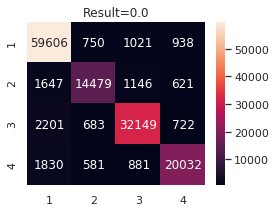

Total= 139287  Classified= 139287 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 126266 Incorrect= 13021 Correct %= 90.65167603581095 Incorrect %= 9.348323964189047


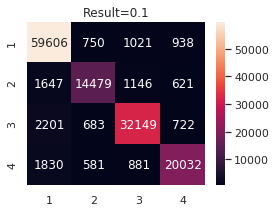

Total= 139287  Classified= 139287 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 126266 Incorrect= 13021 Correct %= 90.65167603581095 Incorrect %= 9.348323964189047


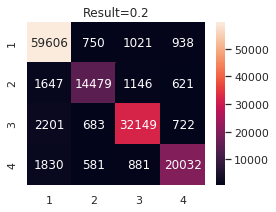

Total= 139287  Classified= 139279 Discarded= 8 recovered percent= 99.99425646327367 discarded percent= 0.005743536726327654
Correct= 126266 Incorrect= 13013 Correct %= 90.65688294717796 Incorrect %= 9.343117052822034


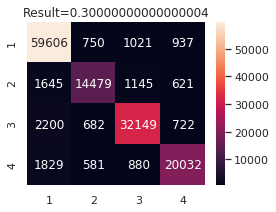

Total= 139287  Classified= 138785 Discarded= 502 recovered percent= 99.63959307042293 discarded percent= 0.3604069295770603
Correct= 126130 Incorrect= 12655 Correct %= 90.88157942140721 Incorrect %= 9.118420578592787


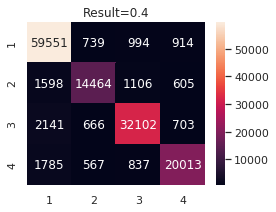

Total= 139287  Classified= 136992 Discarded= 2295 recovered percent= 98.35232290163476 discarded percent= 1.647677098365246
Correct= 125495 Incorrect= 11497 Correct %= 91.60753912637234 Incorrect %= 8.392460873627657


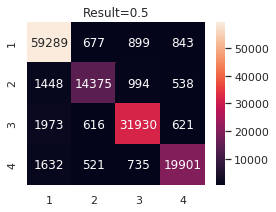

Total= 139287  Classified= 133371 Discarded= 5916 recovered percent= 95.75265459088071 discarded percent= 4.2473454091193
Correct= 123953 Incorrect= 9418 Correct %= 92.93849487519775 Incorrect %= 7.061505124802244


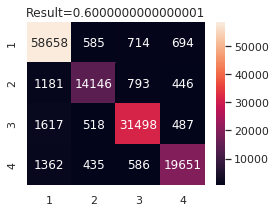

Total= 139287  Classified= 129652 Discarded= 9635 recovered percent= 93.08262795522914 discarded percent= 6.917372044770868
Correct= 122118 Incorrect= 7534 Correct %= 94.18905994508377 Incorrect %= 5.810940054916237


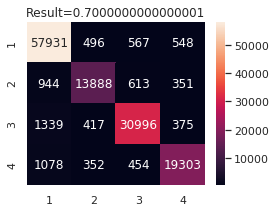

Total= 139287  Classified= 125458 Discarded= 13829 recovered percent= 90.07157882645186 discarded percent= 9.928421173548143
Correct= 119755 Incorrect= 5703 Correct %= 95.45425560745429 Incorrect %= 4.545744392545712


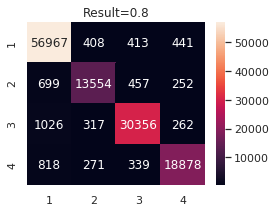

Total= 139287  Classified= 119452 Discarded= 19835 recovered percent= 85.75961862916137 discarded percent= 14.240381370838628
Correct= 115721 Incorrect= 3731 Correct %= 96.87656966815122 Incorrect %= 3.1234303318487764


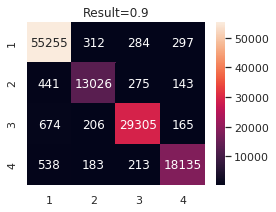

In [49]:
from pycm import *
stats={}
for threshold in np.arange(0,1,0.1):
    result=cm_for_threshold(LX_test,y_test_predicted,y_test,threshold=threshold,dump_errors=True)
    print("Total=",result['total']," Classified=", result['recovered'], 
          "Discarded=",result['discarded'], "recovered percent=",result['recovered']/result['total'] *100, "discarded percent=",(result['total']-result['recovered'])/result['total']*100)
    print('Correct=',result['correct'],'Incorrect=',result['incorrect'], 
          'Correct %=',result['correct']/result['recovered'] * 100,'Incorrect %=',result['incorrect']/result['recovered'] * 100) 
    cm=result['cm']
    cm_heatmap_for(cm.table, threshold)
#    print(cm)
    stats[str(threshold)]=result

In [50]:
def export_errors(file_name,labels, predictions, actuals):
    with open(run+"/"+file_name, "w") as file:
        for index,pred in enumerate(predictions):
            if actuals[index]!=pred:
                file.write(labels[index]+','+ str(pred)+ ','+str(actuals[index])+'\n')
                
def export_matrix(file_name,labels, matrix):
    with open(run+"/"+file_name, "w") as file:
        for index,mat_row in enumerate(matrix):
            file.write(labels[index])
            for elem in mat_row:
                file.write(','+ str(elem))
            file.write('\n')
                

In [51]:
export_matrix('rep5-test_predictions-on-rep2-4.csv',LX_test, y_test_predicted)
export_matrix('rep5-test_actuals.csv',LX_test, y_test)


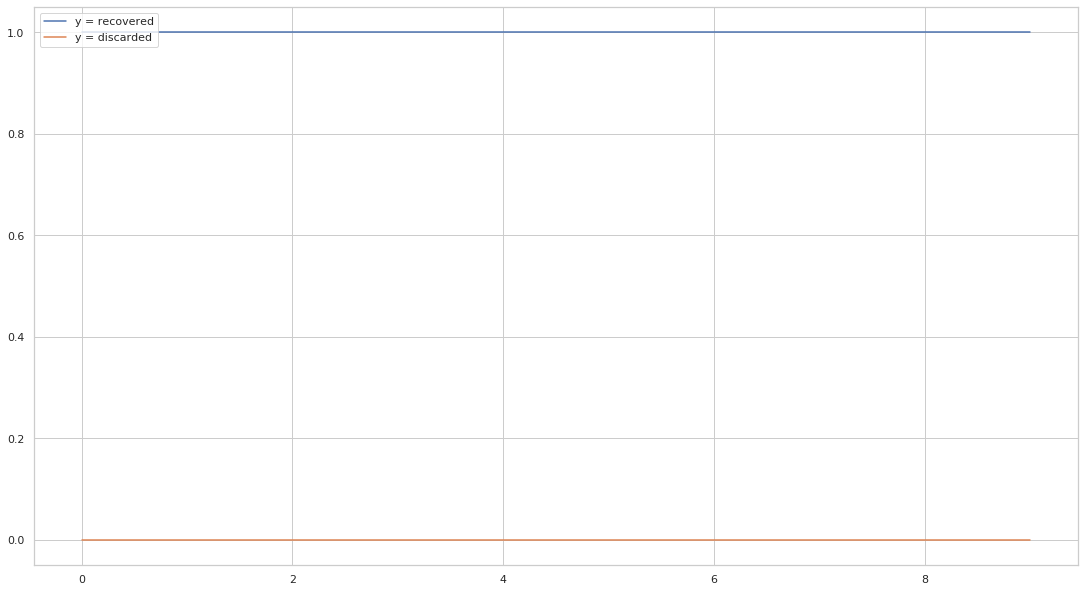

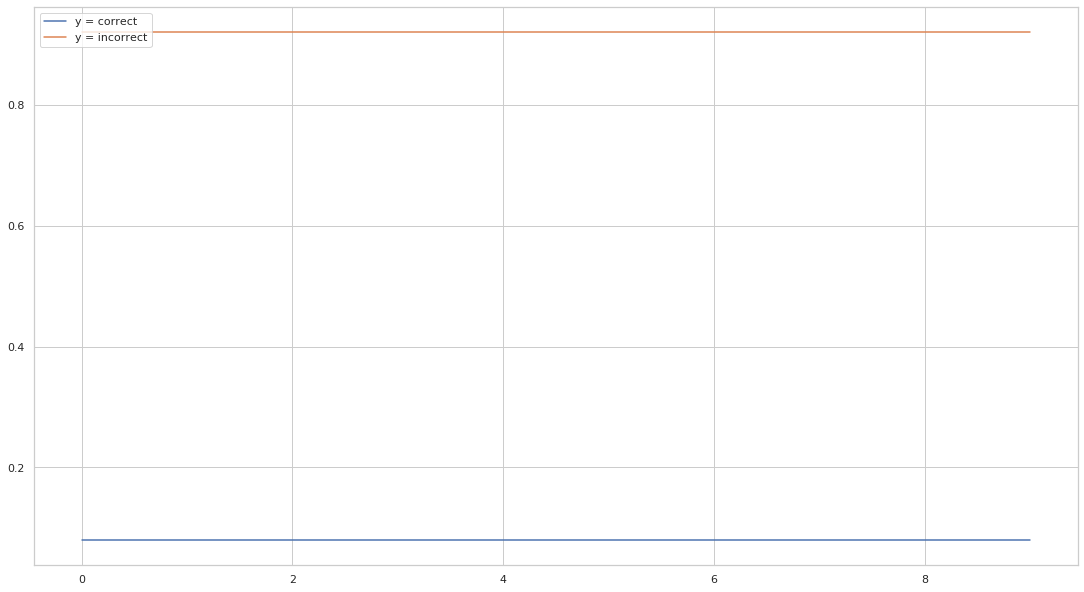

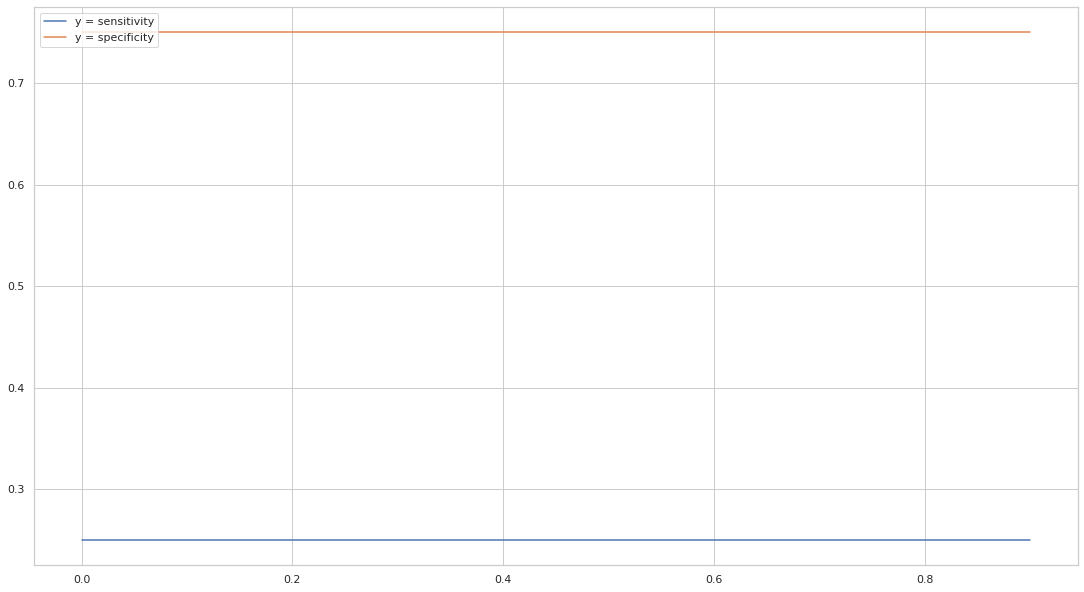

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08] [0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92] [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
0.0 1.0 0.0 0.08 0.92
0.1 1.0 0.0 0.08 0.92
0.2 1.0 0.0 0.08 0.92
0.30000000000000004 1.0 0.0 0.08 0.92
0.4 1.0 0.0 0.08 0.92
0.5 1.0 0.0 0.08 0.92
0.6000000000000001 1.0 0.0 0.08 0.92
0.7000000000000001 1.0 0.0 0.08 0.92
0.8 1.0 0.0 0.08 0.92
0.9 1.0 0.0 0.08 0.92


In [83]:
def calc_avg(dict):
    vals=np.array(list(dict.values()))
    return(np.mean(vals))

def calculate_stats(result):
    confidence=[]
    recovered=[]
    discarded=[]
    correct=[]
    incorrect=[]
    accuracy=[]    
    sensitivity=[]
    specificity=[]
    roc=[]
    for conf,scores in result.items():
        confidence.append(float(conf))
        recovered.append(scores['recovered']/scores['total'])
        discarded.append(scores['discarded']/scores['total'])
        correct.append(scores['correct']/scores['recovered'])
        incorrect.append(scores['incorrect']/scores['recovered'])
        accuracy.append(scores['cm'].Overall_ACC)
        sensitivity.append(calc_avg(scores['cm'].TPR))
        specificity.append(calc_avg(scores['cm'].TNR))
        roc.append(calc_avg(scores['cm'].AUC))    
    return(confidence,recovered,discarded,correct,incorrect,accuracy,sensitivity,specificity,roc)
        
    plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

def graph_summary_for(result):
    confidence,recovered,discarded,correct,incorrect,accuracy,sensitivity,specificity,roc=calculate_stats(result)
    plt.plot(recovered)
    plt.plot(discarded)
    plt.legend(['y = recovered', 'y = discarded'], loc='upper left')
    plt.show()
    
    plt.plot(correct)
    plt.plot(incorrect)
    plt.legend(['y = correct', 'y = incorrect'], loc='upper left')
    plt.show()
    
    plt.plot(confidence,sensitivity)
    plt.plot(confidence,specificity)
    plt.legend(['y = sensitivity', 'y = specificity'], loc='upper left')
    plt.show()
    print(confidence,recovered,discarded,correct,incorrect,accuracy)
    for index,cf in enumerate(confidence):
        print(cf,recovered[index],discarded[index],correct[index],incorrect[index])

graph_summary_for(stats)

[2584, 2304, 280, 0.891640866873065, 0.10835913312693499]
Predict          1      2      3      4      
Actual
1                516    43     20     15     

2                121    271    12     7      

3                4      12     762    13     

4                7      11     15     755    





Overall Statistics : 

95% CI                                                           (0.87966,0.90363)
AUNP                                                             0.9288
AUNU                                                             0.91339
Bennett S                                                        0.85552
CBA                                                              0.83832
Chi-Squared                                                      5459.63637
Chi-Squared DF                                                   9
Conditional Entropy                                              0.53897
Cramer V                                                         0.83922
Cross Entro

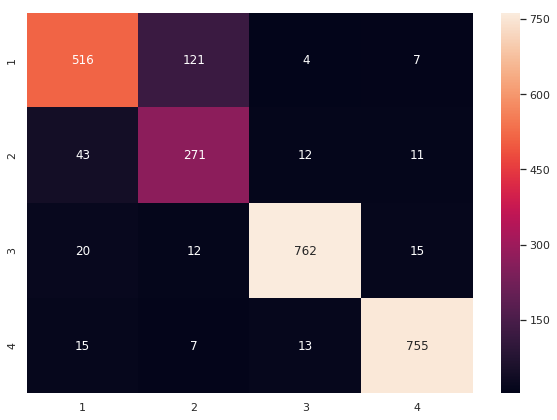

In [42]:
cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
cm_table=cm.table
print(totals_for(cm_table))
print(cm)
#cm.relabel(mapping={0:"117",1:"63",2:"81",3:"103",4:"999"})
df_cm = pd.DataFrame(cm.table, index =[1,2,3,4],
                  columns = [1,2,3,4])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g' )

In [ ]:
threshold=0.9
pv,av=vectorise_selected_with_threshold(y_test_predicted,y_test,threshold)
recognised=np.count_nonzero(pv)


In [ ]:
cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
cm_table=cm.table
print(totals_for(cm_table))
print(cm)
#cm.relabel(mapping={0:"117",1:"63",2:"81",3:"103",4:"999"})
df_cm = pd.DataFrame(cm.table, index =[1,2,3,4],
                  columns = [1,2,3,4])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g' )